In [24]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# Statistical comparison between comparison types
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")


import matplotlib.colors as mcolors




Libraries loaded successfully!


## analyze LLM evaluations (human-human baseline)

In [3]:
# Load the evaluation results
evaluation_file = "/Users/eveyhuang/Documents/NICO/AI-human-scientist/qualitative_evaluation/pairwise_human-human_proposal_overlap/evaluations_pairwise_human-human_20251030_155122.json"

with open(evaluation_file, 'r') as f:
    data = json.load(f)

print(f"Loaded {data['metadata']['total_evaluations']} evaluations")
print(f"Evaluation type: {data['metadata']['evaluation_type']}")

# Get all evaluations
evaluations = data['evaluations']
print(f"\nNumber of evaluations: {len(evaluations)}")


Loaded 110 evaluations
Evaluation type: pairwise_human-human

Number of evaluations: 110


In [4]:
# Extract unique proposal IDs and create mapping
proposal_ids = set()
for eval_data in evaluations:
    proposal_ids.add(eval_data['proposal_1_id'])
    proposal_ids.add(eval_data['proposal_2_id'])

# Sort proposal IDs for consistent ordering
proposal_ids = sorted(list(proposal_ids))
n_proposals = len(proposal_ids)

print(f"Number of unique proposals: {n_proposals}")
print(f"Proposal IDs: {proposal_ids}")

# Create index mapping
id_to_idx = {pid: idx for idx, pid in enumerate(proposal_ids)}
print(f"\nID to index mapping created")


Number of unique proposals: 11
Proposal IDs: ['human_1', 'human_10', 'human_11', 'human_12', 'human_2', 'human_3', 'human_4', 'human_5', 'human_6', 'human_7', 'human_9']

ID to index mapping created


In [4]:
# Extract dimension names
dimension_names = []
if evaluations and 'evaluation_response' in evaluations[0]:
    comparison = evaluations[0]['evaluation_response'].get('comparison', {})
    dimensions = comparison.get('dimensions', [])
    dimension_names = [d['dimension'] for d in dimensions]

print(f"Dimensions found: {dimension_names}")

# Initialize matrices for each dimension
matrices = {}
for dim_name in dimension_names:
    # Initialize with NaN
    matrices[dim_name] = np.full((n_proposals, n_proposals), np.nan)

print(f"\nInitialized {len(matrices)} matrices, each of size {n_proposals}x{n_proposals}")


Dimensions found: ['Research Question / Aims', 'Data / Empirical Context', 'Methods / Design', 'Intended Contribution / Outcomes', 'Resources / Timing / Artifacts']

Initialized 5 matrices, each of size 11x11


In [ ]:
# Fill matrices with scores from evaluations
for eval_data in evaluations:
    prop_1_id = eval_data['proposal_1_id']
    prop_2_id = eval_data['proposal_2_id']
    
    # Get indices
    idx_1 = id_to_idx[prop_1_id]
    idx_2 = id_to_idx[prop_2_id]
    
    # Extract scores for each dimension
    if 'evaluation_response' in eval_data:
        comparison = eval_data['evaluation_response'].get('comparison', {})
        dimensions = comparison.get('dimensions', [])
        
        for dim in dimensions:
            dim_name = dim['dimension']
            score = dim['score']
            
            # Fill the matrix (asymmetric comparison)
            if dim_name in matrices:
                matrices[dim_name][idx_1, idx_2] = score

print("Matrices filled with evaluation scores!")
print(f"\nExample: Research Question / Aims matrix shape: {matrices[dimension_names[0]].shape}")


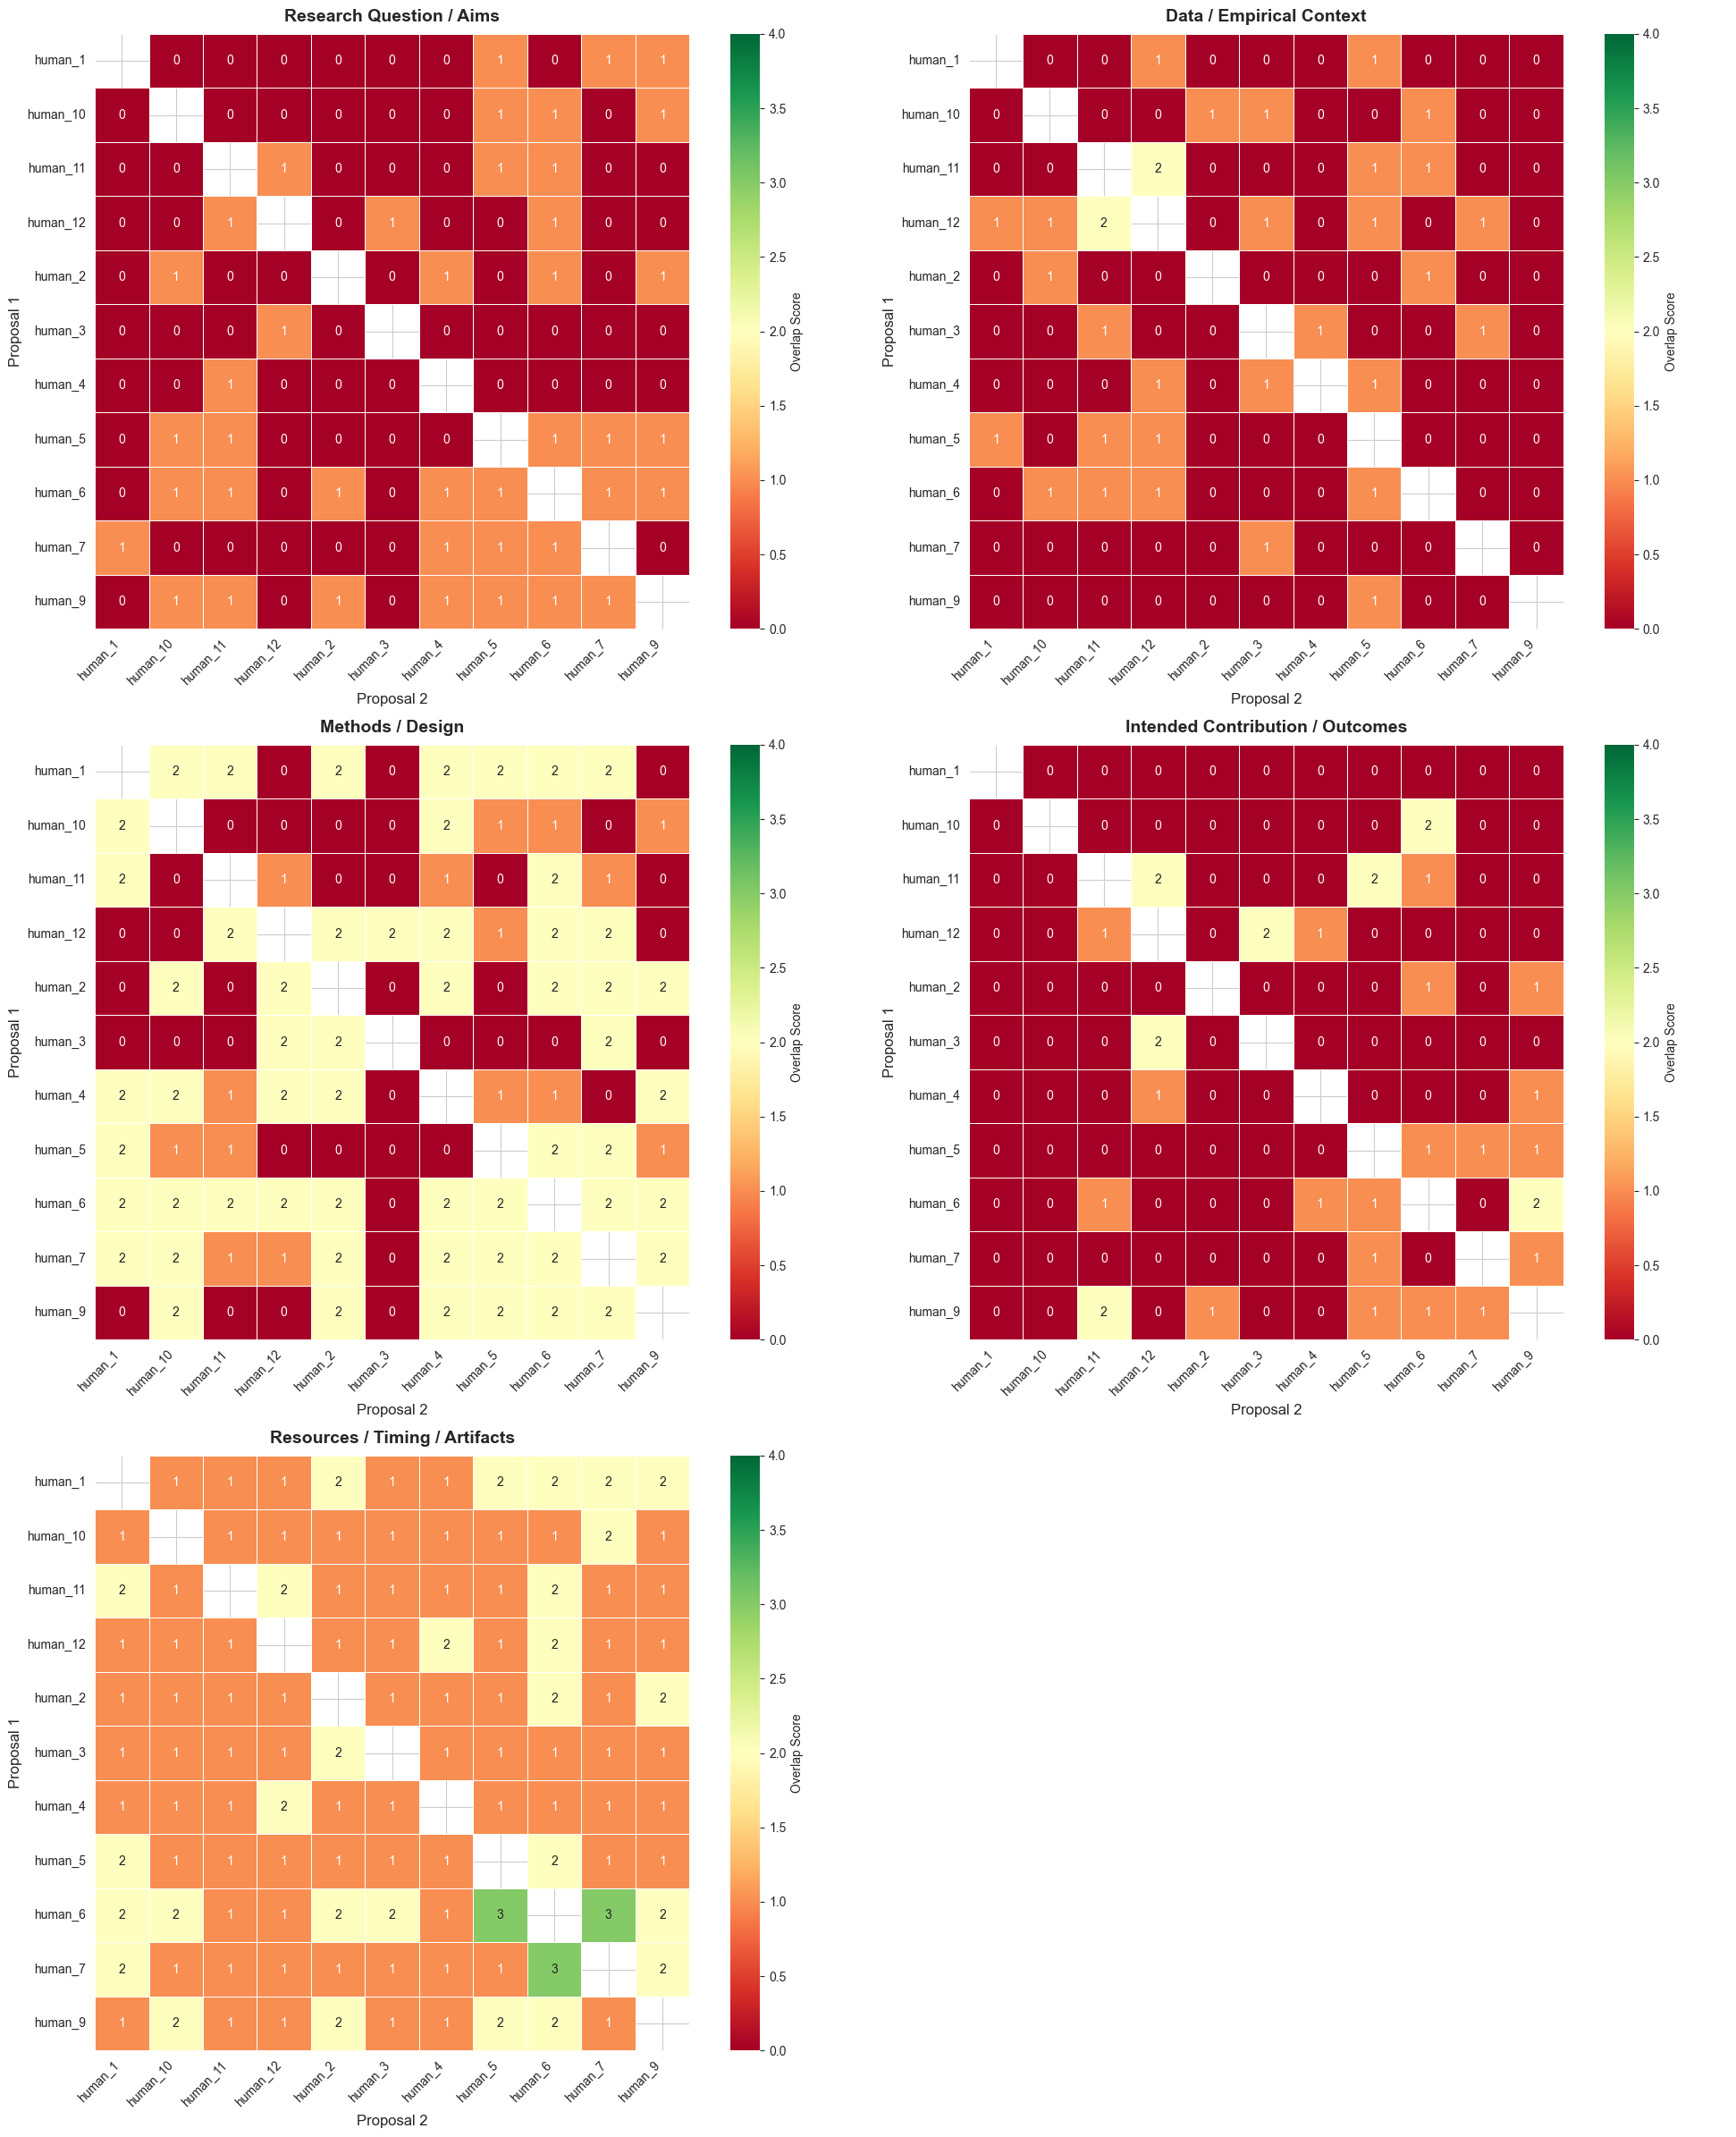

In [6]:
# Create visualizations - one heatmap per dimension
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()

for idx, dim_name in enumerate(dimension_names):
    ax = axes[idx]
    matrix = matrices[dim_name]
    
    # Create heatmap
    sns.heatmap(matrix, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=4,
                cbar_kws={'label': 'Overlap Score'}, xticklabels=proposal_ids,
                yticklabels=proposal_ids, ax=ax, linewidths=0.5, square=True)
    
    ax.set_title(f'{dim_name}', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Proposal 2', fontsize=12)
    ax.set_ylabel('Proposal 1', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

if len(dimension_names) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('evaluations/overlap_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Create individual plots for each dimension (larger, more detailed)
for dim_name in dimension_names:
    fig, ax = plt.subplots(figsize=(14, 12))
    matrix = matrices[dim_name]
    
    sns.heatmap(matrix, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=4,
                cbar_kws={'label': 'Overlap Score (0-4)'}, xticklabels=proposal_ids,
                yticklabels=proposal_ids, ax=ax, linewidths=1, linecolor='white',
                square=True, annot_kws={'size': 11, 'weight': 'bold'})
    
    ax.set_title(f'{dim_name}\nPairwise Overlap Scores', fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Proposal 2 (Compared Against)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Proposal 1 (Reference)', fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    
    plt.tight_layout()
    safe_name = dim_name.replace('/', '_').replace(' ', '_').lower()
    plt.savefig(f'evaluations/matrix_{safe_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: matrix_{safe_name}.png")


In [7]:
# Summary statistics for each dimension
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)

for dim_name in dimension_names:
    matrix = matrices[dim_name]
    valid_scores = matrix[~np.isnan(matrix)]
    
    print(f"\n{dim_name}:")
    print(f"  Mean score: {np.mean(valid_scores):.2f}")
    print(f"  Median score: {np.median(valid_scores):.2f}")
    print(f"  Std dev: {np.std(valid_scores):.2f}")
    print(f"  Min: {np.min(valid_scores):.0f}, Max: {np.max(valid_scores):.0f}")
    print(f"  Score distribution:")
    for score in range(5):
        count = np.sum(valid_scores == score)
        pct = count / len(valid_scores) * 100
        print(f"    Score {score}: {count:3d} ({pct:5.1f}%)")


SUMMARY STATISTICS

Research Question / Aims:
  Mean score: 0.37
  Median score: 0.00
  Std dev: 0.48
  Min: 0, Max: 1
  Score distribution:
    Score 0:  69 ( 62.7%)
    Score 1:  41 ( 37.3%)
    Score 2:   0 (  0.0%)
    Score 3:   0 (  0.0%)
    Score 4:   0 (  0.0%)

Data / Empirical Context:
  Mean score: 0.30
  Median score: 0.00
  Std dev: 0.50
  Min: 0, Max: 2
  Score distribution:
    Score 0:  79 ( 71.8%)
    Score 1:  29 ( 26.4%)
    Score 2:   2 (  1.8%)
    Score 3:   0 (  0.0%)
    Score 4:   0 (  0.0%)

Methods / Design:
  Mean score: 1.15
  Median score: 2.00
  Std dev: 0.92
  Min: 0, Max: 2
  Score distribution:
    Score 0:  39 ( 35.5%)
    Score 1:  15 ( 13.6%)
    Score 2:  56 ( 50.9%)
    Score 3:   0 (  0.0%)
    Score 4:   0 (  0.0%)

Intended Contribution / Outcomes:
  Mean score: 0.30
  Median score: 0.00
  Std dev: 0.58
  Min: 0, Max: 2
  Score distribution:
    Score 0:  84 ( 76.4%)
    Score 1:  19 ( 17.3%)
    Score 2:   7 (  6.4%)
    Score 3:   0 (  0.0%)

In [8]:
# Find high-overlap proposal pairs (score >= 3 in any dimension)
print("\n" + "="*60)
print("HIGH OVERLAP PAIRS (Score >= 3)")
print("="*60)

for dim_name in dimension_names:
    matrix = matrices[dim_name]
    high_overlap_indices = np.argwhere(matrix >= 3)
    
    if len(high_overlap_indices) > 0:
        print(f"\n{dim_name}:")
        for idx1, idx2 in high_overlap_indices:
            prop1 = proposal_ids[idx1]
            prop2 = proposal_ids[idx2]
            score = matrix[idx1, idx2]
            print(f"  {prop1} vs {prop2}: Score = {score:.0f}")
    else:
        print(f"\n{dim_name}: No high overlap pairs found")



HIGH OVERLAP PAIRS (Score >= 3)

Research Question / Aims: No high overlap pairs found

Data / Empirical Context: No high overlap pairs found

Methods / Design: No high overlap pairs found

Intended Contribution / Outcomes: No high overlap pairs found

Resources / Timing / Artifacts:
  human_6 vs human_5: Score = 3
  human_6 vs human_7: Score = 3
  human_7 vs human_6: Score = 3


Matrices filled with evaluation scores!

Example: Research Question / Aims matrix shape: (11, 11)


# Similarity Analysis Visualization

Now let's visualize the similarity scores from the textual similarity analysis.


In [9]:
# Load similarity analysis results
similarity_file = "similarity_analysis/similarity_human-human_20251030_160213.csv"
similarity_df = pd.read_csv(similarity_file)

print(f"Loaded {len(similarity_df)} similarity comparisons")

Loaded 110 similarity comparisons


In [10]:
# Extract unique proposal IDs from similarity data
sim_proposal_ids = set()
for _, row in similarity_df.iterrows():
    sim_proposal_ids.add(row['proposal_1_id'])
    sim_proposal_ids.add(row['proposal_2_id'])

sim_proposal_ids = sorted(list(sim_proposal_ids))
n_sim_proposals = len(sim_proposal_ids)

print(f"Number of unique proposals: {n_sim_proposals}")
print(f"Proposal IDs: {sim_proposal_ids}")

# Create index mapping
sim_id_to_idx = {pid: idx for idx, pid in enumerate(sim_proposal_ids)}

# Define similarity metrics to visualize
similarity_metrics = [
    'tfidf_similarity',
    'embedding_similarity',
    'keyword_jaccard',
    'topic_similarity'
]

print(f"\nSimilarity metrics to visualize: {similarity_metrics}")


Number of unique proposals: 11
Proposal IDs: ['human_1', 'human_10', 'human_11', 'human_12', 'human_2', 'human_3', 'human_4', 'human_5', 'human_6', 'human_7', 'human_9']

Similarity metrics to visualize: ['tfidf_similarity', 'embedding_similarity', 'keyword_jaccard', 'topic_similarity']


In [11]:
# Initialize matrices for each similarity metric
sim_matrices = {}
for metric in similarity_metrics:
    sim_matrices[metric] = np.full((n_sim_proposals, n_sim_proposals), np.nan)

# Fill matrices with similarity scores
for _, row in similarity_df.iterrows():
    prop_1_id = row['proposal_1_id']
    prop_2_id = row['proposal_2_id']
    
    idx_1 = sim_id_to_idx[prop_1_id]
    idx_2 = sim_id_to_idx[prop_2_id]
    
    for metric in similarity_metrics:
        score = row[metric]
        sim_matrices[metric][idx_1, idx_2] = score

print("Similarity matrices created!")
print(f"Matrix shape: {sim_matrices[similarity_metrics[0]].shape}")


Similarity matrices created!
Matrix shape: (11, 11)


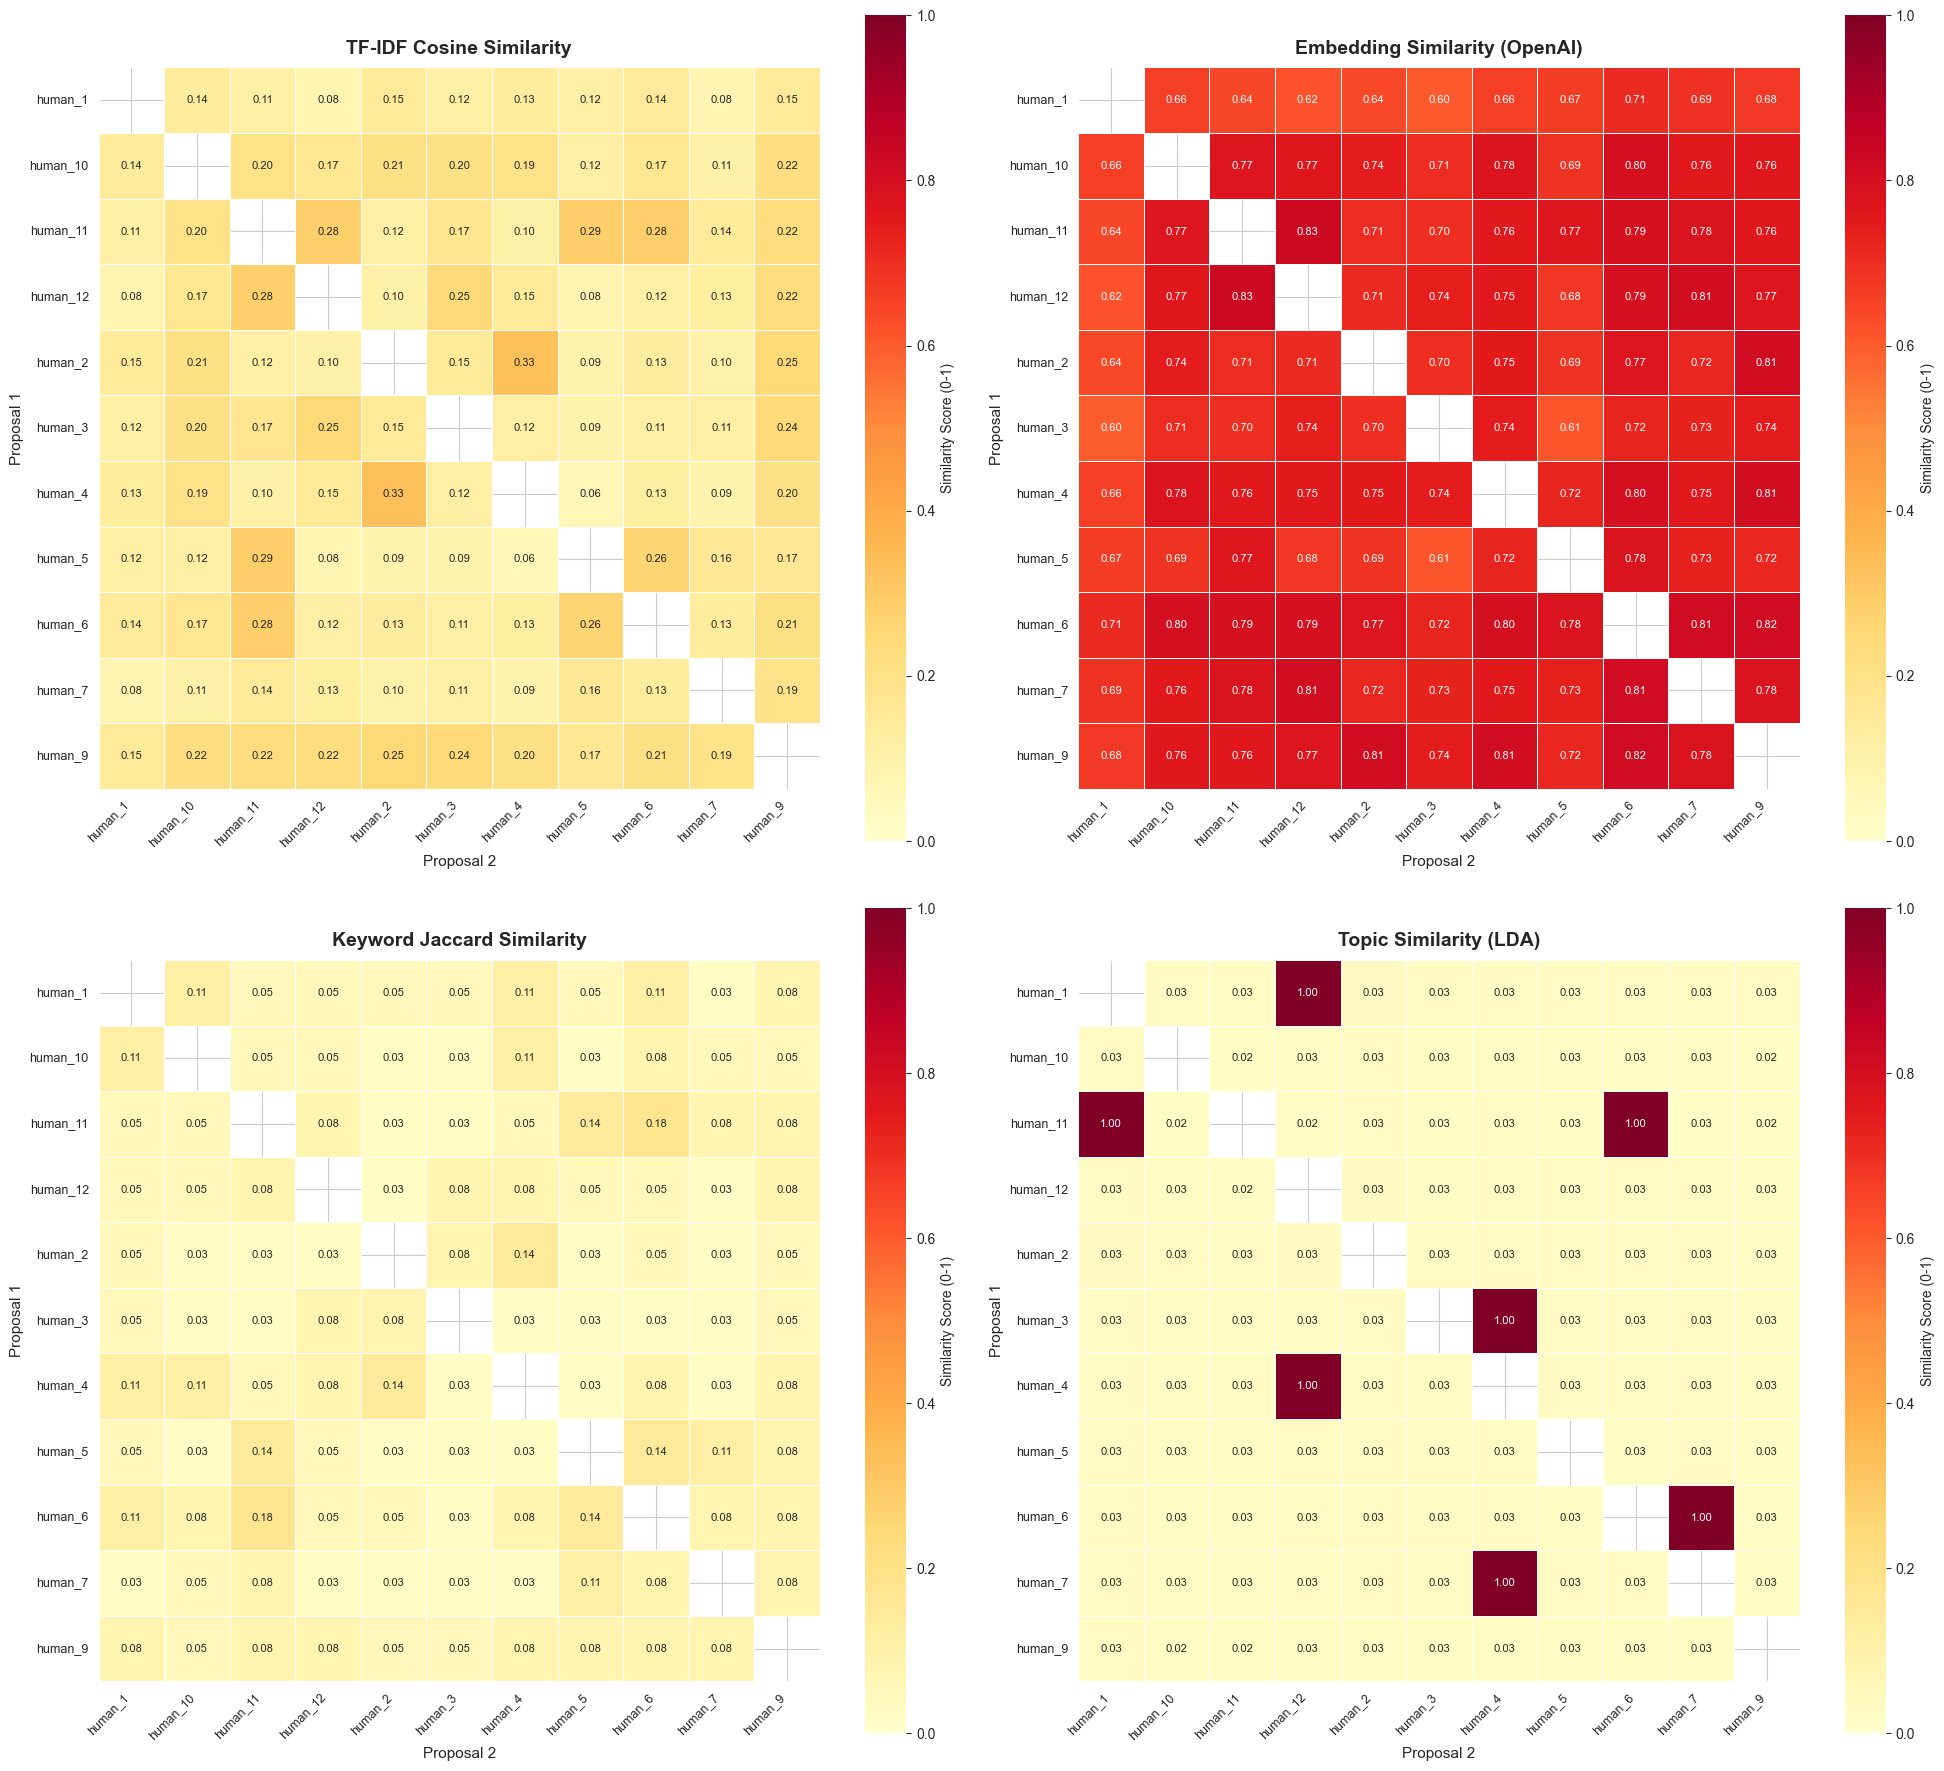

Combined similarity heatmap created!


In [12]:
# Create combined view of all similarity metrics
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten()

# Nice metric names for display
metric_names = {
    'tfidf_similarity': 'TF-IDF Cosine Similarity',
    'embedding_similarity': 'Embedding Similarity (OpenAI)',
    'keyword_jaccard': 'Keyword Jaccard Similarity',
    'topic_similarity': 'Topic Similarity (LDA)'
}

for idx, metric in enumerate(similarity_metrics):
    ax = axes[idx]
    matrix = sim_matrices[metric]
    
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='YlOrRd', vmin=0, vmax=1,
                cbar_kws={'label': 'Similarity Score (0-1)'}, xticklabels=sim_proposal_ids,
                yticklabels=sim_proposal_ids, ax=ax, linewidths=0.5, square=True,
                annot_kws={'size': 8})
    
    ax.set_title(metric_names[metric], fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Proposal 2', fontsize=11)
    ax.set_ylabel('Proposal 1', fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('similarity_analysis/similarity_matrices_combined.png', dpi=300, bbox_inches='tight')
plt.show()

print("Combined similarity heatmap created!")


In [ ]:
# Create individual detailed heatmaps for each similarity metric
for metric in similarity_metrics:
    fig, ax = plt.subplots(figsize=(14, 12))
    matrix = sim_matrices[metric]
    
    sns.heatmap(matrix, annot=True, fmt='.3f', cmap='YlOrRd', vmin=0, vmax=1,
                cbar_kws={'label': 'Similarity Score (0-1)'}, xticklabels=sim_proposal_ids,
                yticklabels=sim_proposal_ids, ax=ax, linewidths=1, linecolor='white',
                square=True, annot_kws={'size': 10, 'weight': 'bold'})
    
    ax.set_title(f'{metric_names[metric]}\nPairwise Similarity Scores', 
                 fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Proposal 2 (Compared Against)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Proposal 1 (Reference)', fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    
    plt.tight_layout()
    safe_name = metric.replace('_', '_')
    plt.savefig(f'similarity_analysis/matrix_{safe_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: matrix_{safe_name}.png")


In [13]:
# Summary statistics for similarity metrics
print("="*70)
print("SIMILARITY METRICS SUMMARY STATISTICS")
print("="*70)

for metric in similarity_metrics:
    matrix = sim_matrices[metric]
    valid_scores = matrix[~np.isnan(matrix)]
    
    print(f"\n{metric_names[metric]}:")
    print(f"  Mean: {np.mean(valid_scores):.4f}")
    print(f"  Median: {np.median(valid_scores):.4f}")
    print(f"  Std dev: {np.std(valid_scores):.4f}")
    print(f"  Min: {np.min(valid_scores):.4f}, Max: {np.max(valid_scores):.4f}")
    print(f"  Range: {np.max(valid_scores) - np.min(valid_scores):.4f}")
    
    # Percentiles
    p25, p50, p75 = np.percentile(valid_scores, [25, 50, 75])
    print(f"  Percentiles: 25th={p25:.4f}, 50th={p50:.4f}, 75th={p75:.4f}")


SIMILARITY METRICS SUMMARY STATISTICS

TF-IDF Cosine Similarity:
  Mean: 0.1594
  Median: 0.1449
  Std dev: 0.0622
  Min: 0.0599, Max: 0.3282
  Range: 0.2683
  Percentiles: 25th=0.1128, 50th=0.1449, 75th=0.2011

Embedding Similarity (OpenAI):
  Mean: 0.7345
  Median: 0.7439
  Std dev: 0.0552
  Min: 0.6015, Max: 0.8263
  Range: 0.2248
  Percentiles: 25th=0.7000, 50th=0.7439, 75th=0.7752

Keyword Jaccard Similarity:
  Mean: 0.0650
  Median: 0.0526
  Std dev: 0.0362
  Min: 0.0256, Max: 0.1765
  Range: 0.1508
  Percentiles: 25th=0.0256, 50th=0.0526, 75th=0.0811

Topic Similarity (LDA):
  Mean: 0.0896
  Median: 0.0279
  Std dev: 0.2373
  Min: 0.0241, Max: 1.0000
  Range: 0.9759
  Percentiles: 25th=0.0262, 50th=0.0279, 75th=0.0297


In [ ]:
# Correlation between different similarity metrics
print("\n" + "="*70)
print("CORRELATION BETWEEN SIMILARITY METRICS")
print("="*70)

# Flatten all matrices and compute correlation
correlation_data = {}
for metric in similarity_metrics:
    matrix = sim_matrices[metric]
    # Flatten and remove NaN
    correlation_data[metric] = matrix.flatten()

# Create correlation dataframe
corr_df = pd.DataFrame(correlation_data)
correlation_matrix = corr_df.corr()

print("\nPearson Correlation Matrix:")
print(correlation_matrix)

# Visualize correlation
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, square=True, linewidths=1,
            xticklabels=[metric_names[m] for m in similarity_metrics],
            yticklabels=[metric_names[m] for m in similarity_metrics],
            cbar_kws={'label': 'Correlation Coefficient'})

ax.set_title('Correlation Between Similarity Metrics', fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('similarity_analysis/metrics_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation heatmap saved!")


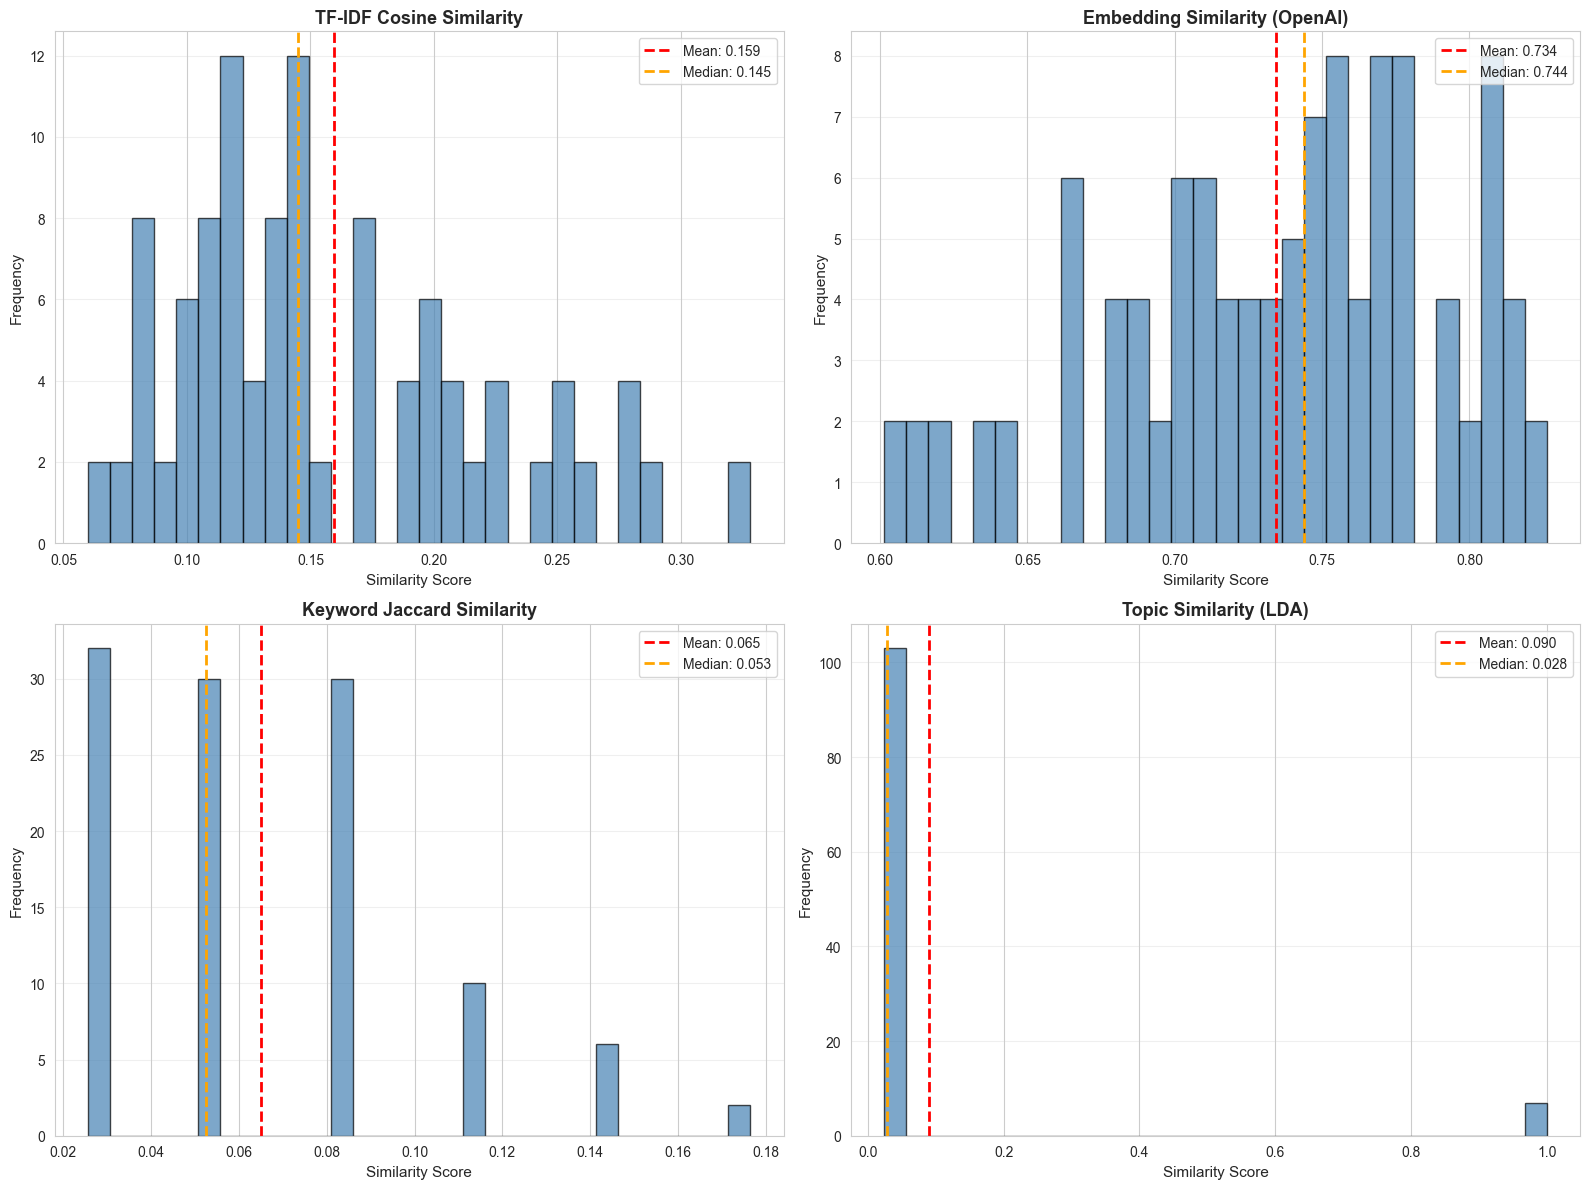

Distribution plots saved!


In [14]:
# Distribution plots for each similarity metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, metric in enumerate(similarity_metrics):
    ax = axes[idx]
    matrix = sim_matrices[metric]
    valid_scores = matrix[~np.isnan(matrix)]
    
    # Create histogram
    ax.hist(valid_scores, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(np.mean(valid_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(valid_scores):.3f}')
    ax.axvline(np.median(valid_scores), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(valid_scores):.3f}')
    
    ax.set_title(metric_names[metric], fontsize=13, fontweight='bold')
    ax.set_xlabel('Similarity Score', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('similarity_analysis/similarity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Distribution plots saved!")


In [ ]:
# Find high similarity proposal pairs (top 10% for each metric)
print("\n" + "="*70)
print("HIGH SIMILARITY PAIRS (Top 10% for each metric)")
print("="*70)

for metric in similarity_metrics:
    matrix = sim_matrices[metric]
    valid_scores = matrix[~np.isnan(matrix)]
    threshold = np.percentile(valid_scores, 90)  # Top 10%
    
    high_sim_indices = np.argwhere(matrix >= threshold)
    
    print(f"\n{metric_names[metric]} (threshold >= {threshold:.4f}):")
    
    # Sort by score (descending)
    pairs_with_scores = []
    for idx1, idx2 in high_sim_indices:
        prop1 = sim_proposal_ids[idx1]
        prop2 = sim_proposal_ids[idx2]
        score = matrix[idx1, idx2]
        pairs_with_scores.append((prop1, prop2, score))
    
    pairs_with_scores.sort(key=lambda x: x[2], reverse=True)
    
    for prop1, prop2, score in pairs_with_scores[:10]:  # Show top 10
        print(f"  {prop1} vs {prop2}: {score:.4f}")


In [ ]:
# Load similarity analysis results
similarity_file = "similarity_analysis/similarity_human-human_20251030_160213.csv"
similarity_df = pd.read_csv(similarity_file)

print(f"Loaded {len(similarity_df)} similarity comparisons")
print(f"\nColumns: {list(similarity_df.columns)}")
print(f"\nFirst few rows:")
similarity_df.head()


# Histogram Analysis: Comparing Evaluation Score Distributions

Compare evaluation scores across different comparison types (AI-AI vs Human-AI vs Human-Human)


### Qualitative rating on overlap

In [ ]:
# Define paths to evaluation files for comparison
evaluation_files = {
    'Human-Human': '/Users/eveyhuang/Documents/NICO/AI-human-scientist/qualitative_evaluation/pairwise_human-human_proposal_overlap/evaluations_pairwise_human-human_20251030_155122.json',   
    'AI-AI': '/Users/eveyhuang/Documents/NICO/AI-human-scientist/qualitative_evaluation/pairwise-ai-ai_generate_ideas_no_role_genby_gemini_eval_gemini_proposal_overlap/evaluations_pairwise_ai-ai_20251031_120326.json',
    # 'Human-AI': 'path/to/human-ai/evaluations.json',
}

print("Evaluation files to compare:")
for comp_type, path in evaluation_files.items():
    print(f"  {comp_type}: {Path(path).name}")
    print(f"    Exists: {Path(path).exists()}")


Evaluation files to compare:
  Human-Human: evaluations_pairwise_human-human_20251030_155122.json
    Exists: True
  AI-AI: evaluations_pairwise_ai-ai_20251031_120326.json
    Exists: True


In [6]:
# Load and extract scores from all evaluation files
def extract_scores_from_evaluations(eval_file_path):
    """Extract all dimension scores from an evaluation file"""
    with open(eval_file_path, 'r') as f:
        data = json.load(f)
    
    evaluations = data['evaluations']
    
    # Dictionary to store scores by dimension
    dimension_scores = {}
    
    for eval_data in evaluations:
        if 'evaluation_response' in eval_data:
            comparison = eval_data['evaluation_response'].get('comparison', {})
            dimensions = comparison.get('dimensions', [])
            
            for dim in dimensions:
                dim_name = dim['dimension']
                score = dim['score']
                
                if dim_name not in dimension_scores:
                    dimension_scores[dim_name] = []
                dimension_scores[dim_name].append(score)
    
    return dimension_scores

# Extract scores from all evaluation files
all_scores = {}
for comp_type, eval_file in evaluation_files.items():
    if Path(eval_file).exists():
        all_scores[comp_type] = extract_scores_from_evaluations(eval_file)
        print(f"Loaded {comp_type}: {len(all_scores[comp_type])} dimensions")
        for dim_name, scores in all_scores[comp_type].items():
            print(f"  {dim_name}: {len(scores)} scores")
    else:
        print(f"Warning: {comp_type} file not found!")

print(f"\nTotal comparison types loaded: {len(all_scores)}")


Loaded Human-Human: 5 dimensions
  Research Question / Aims: 110 scores
  Data / Empirical Context: 110 scores
  Methods / Design: 110 scores
  Intended Contribution / Outcomes: 110 scores
  Resources / Timing / Artifacts: 110 scores
Loaded AI-AI: 5 dimensions
  Research Question / Aims: 90 scores
  Data / Empirical Context: 90 scores
  Methods / Design: 90 scores
  Intended Contribution / Outcomes: 90 scores
  Resources / Timing / Artifacts: 90 scores

Total comparison types loaded: 2


Found 5 dimensions:
  - Data / Empirical Context
  - Intended Contribution / Outcomes
  - Methods / Design
  - Research Question / Aims
  - Resources / Timing / Artifacts


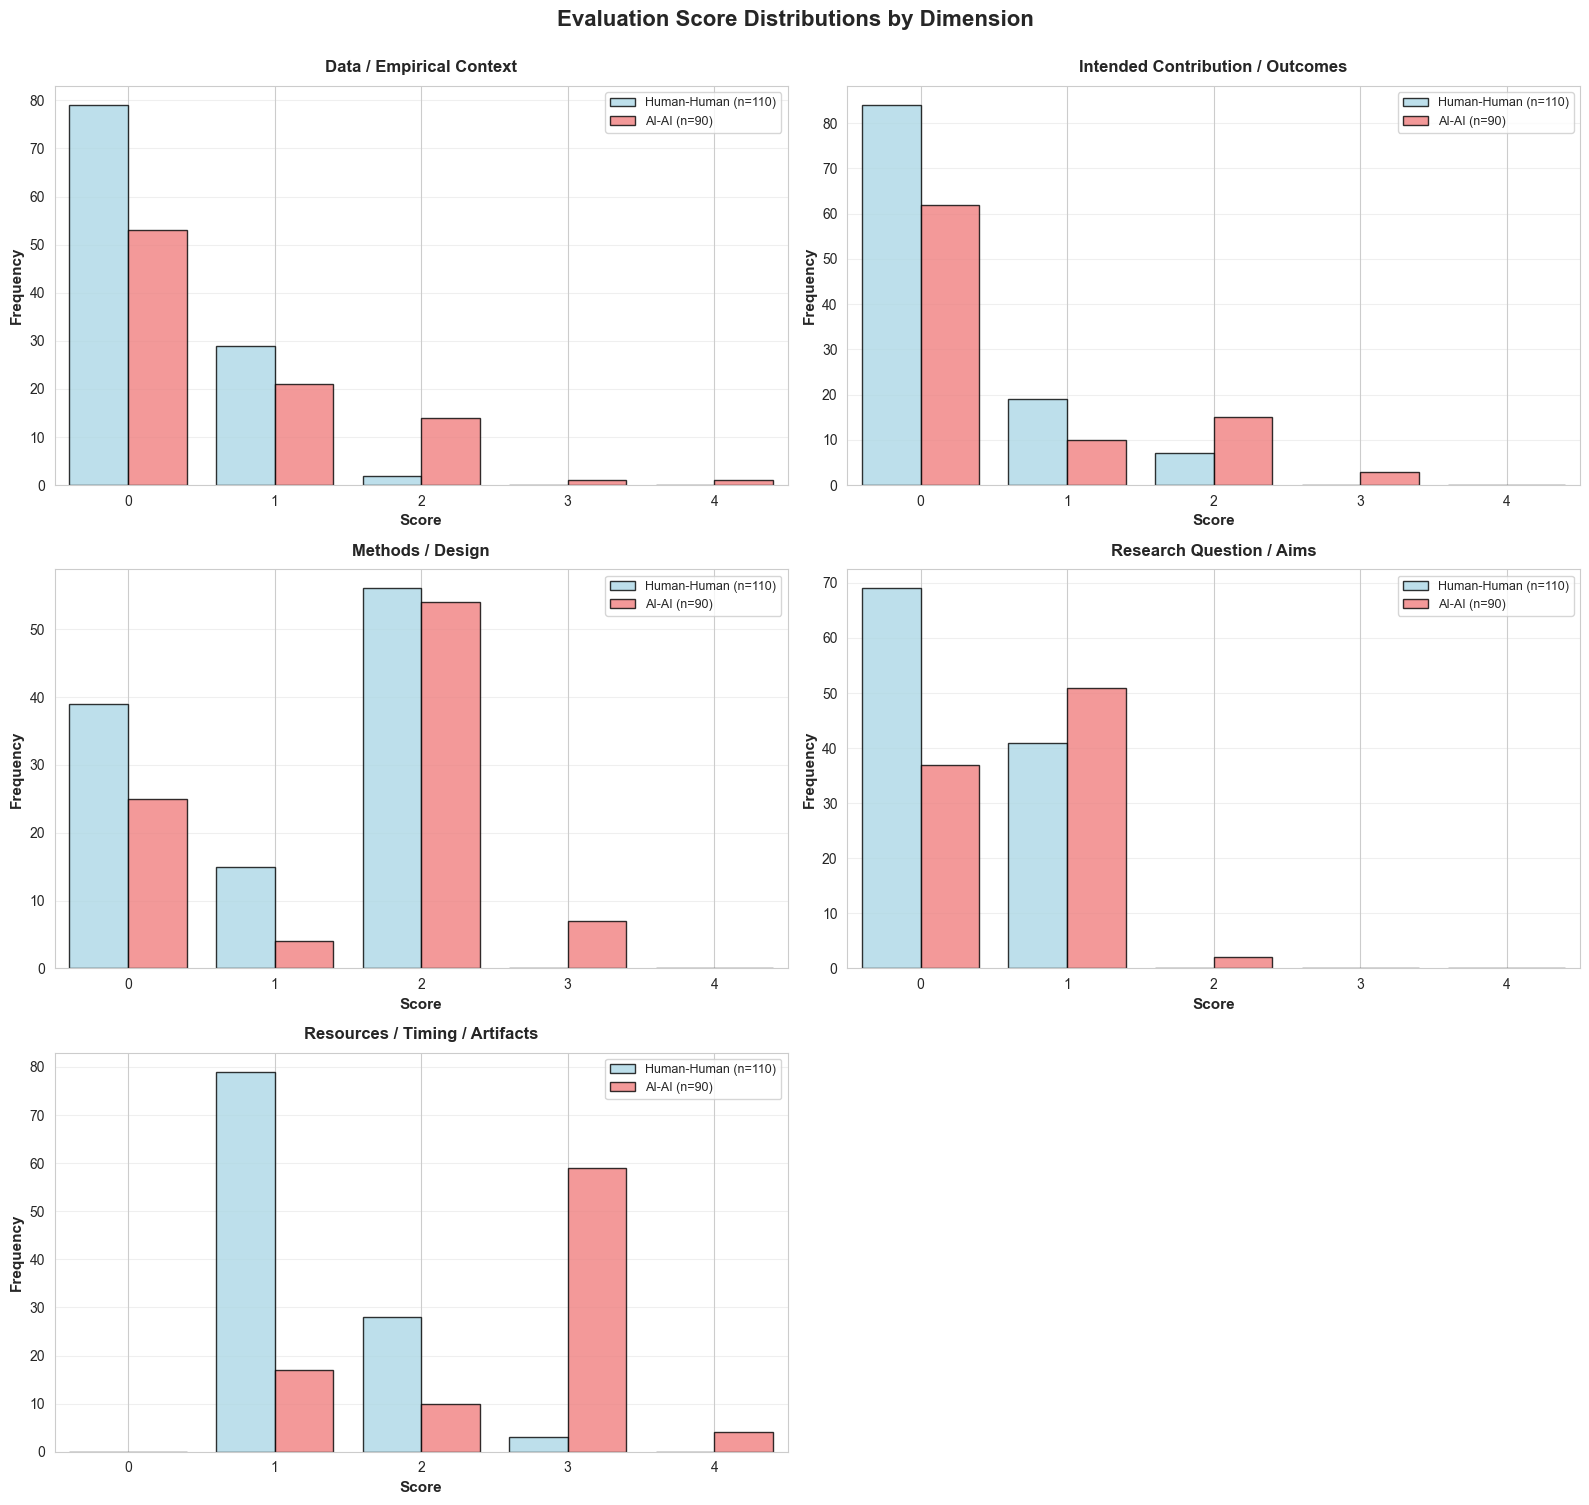


Comparative histogram saved!


In [9]:
# Create comparative histograms for all dimensions
# Get all unique dimensions
all_dimensions = set()
for comp_type_scores in all_scores.values():
    all_dimensions.update(comp_type_scores.keys())
all_dimensions = sorted(list(all_dimensions))

print(f"Found {len(all_dimensions)} dimensions:")
for dim in all_dimensions:
    print(f"  - {dim}")

# Define colors for each comparison type
colors = {
    'Human-Human': 'lightblue',
    'AI-AI': 'lightcoral',
    'Human-AI': 'lightgreen'
}

# Create combined histogram plot for all dimensions
n_dims = len(all_dimensions)
n_cols = 2
n_rows = (n_dims + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] if n_cols == 1 else axes.flatten()

# Possible scores
score_values = np.arange(5)  # 0, 1, 2, 3, 4

for idx, dim_name in enumerate(all_dimensions):
    ax = axes[idx]
    
    # Get comparison types that have this dimension
    comp_types_with_dim = [ct for ct in all_scores.keys() if dim_name in all_scores[ct]]
    n_comp_types = len(comp_types_with_dim)
    
    # Calculate bar width and positions
    bar_width = 0.8 / n_comp_types if n_comp_types > 0 else 0.8
    
    # Plot bars for each comparison type (side-by-side)
    for i, comp_type in enumerate(comp_types_with_dim):
        scores = all_scores[comp_type][dim_name]
        
        # Count frequency of each score
        counts = [np.sum(np.array(scores) == score) for score in score_values]
        
        # Calculate x positions (offset for each comparison type)
        x_positions = score_values + (i - n_comp_types/2 + 0.5) * bar_width
        
        ax.bar(x_positions, counts, width=bar_width, 
               label=f'{comp_type} (n={len(scores)})',
               color=colors.get(comp_type, 'gray'),
               edgecolor='black', linewidth=1, alpha=0.8)
    
    ax.set_xlabel('Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(dim_name, fontsize=12, fontweight='bold', pad=10)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticks(score_values)
    ax.set_xlim(-0.5, 4.5)

# Hide unused subplots
for idx in range(len(all_dimensions), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Evaluation Score Distributions by Dimension', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
# plt.savefig('evaluations/score_distributions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparative histogram saved!")


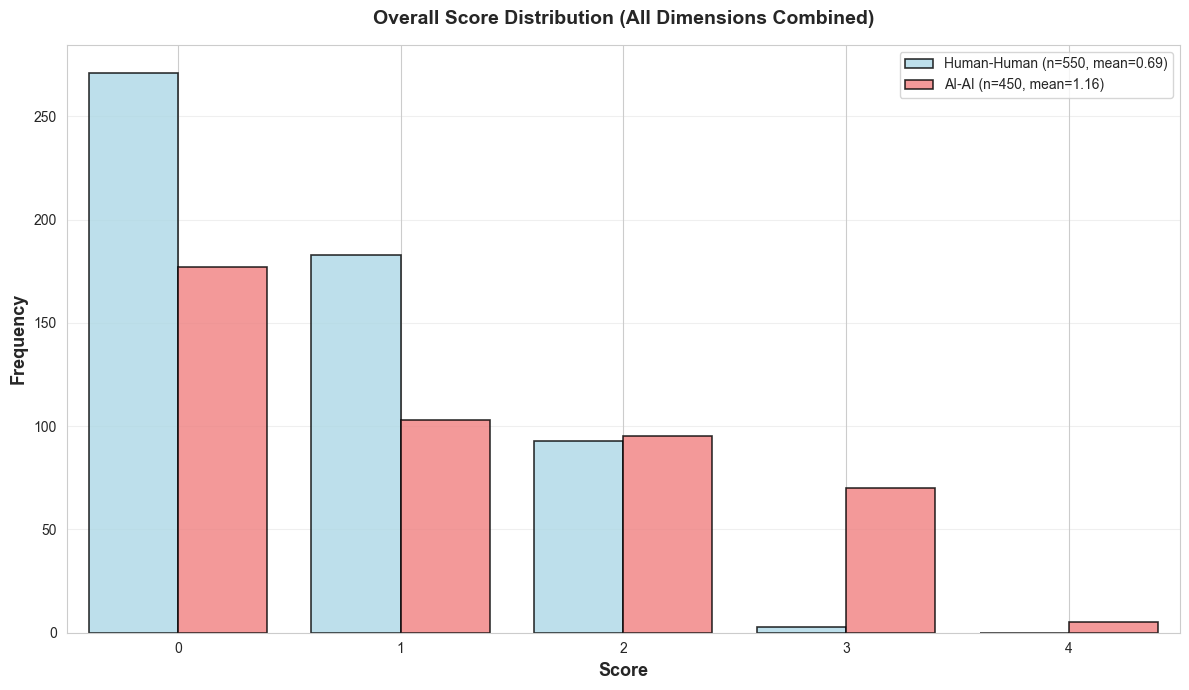

Overall distribution histogram saved!


In [10]:
# Create overall score distribution (all dimensions combined)
fig, ax = plt.subplots(figsize=(12, 7))

# Possible scores
score_values = np.arange(5)

# Get all comparison types
comp_types_list = list(all_scores.keys())
n_comp_types = len(comp_types_list)
bar_width = 0.8 / n_comp_types if n_comp_types > 0 else 0.8

# Plot bars for each comparison type (side-by-side)
for i, comp_type in enumerate(comp_types_list):
    comp_scores = all_scores[comp_type]
    
    # Combine all scores from all dimensions
    all_comp_scores = []
    for dim_scores in comp_scores.values():
        all_comp_scores.extend(dim_scores)
    
    # Count frequency of each score
    counts = [np.sum(np.array(all_comp_scores) == score) for score in score_values]
    
    # Calculate x positions (offset for each comparison type)
    x_positions = score_values + (i - n_comp_types/2 + 0.5) * bar_width
    
    ax.bar(x_positions, counts, width=bar_width,
           label=f'{comp_type} (n={len(all_comp_scores)}, mean={np.mean(all_comp_scores):.2f})', 
           color=colors.get(comp_type, 'gray'),
           edgecolor='black', linewidth=1.2, alpha=0.8)

ax.set_xlabel('Score', fontsize=13, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax.set_title('Overall Score Distribution (All Dimensions Combined)', 
            fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(score_values)
ax.set_xlim(-0.5, 4.5)

plt.tight_layout()
#plt.savefig('evaluations/overall_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Overall distribution histogram saved!")


In [11]:
# Comparative summary statistics
print("="*80)
print("COMPARATIVE SUMMARY STATISTICS")
print("="*80)

for comp_type, comp_scores in all_scores.items():
    print(f"\n{'='*80}")
    print(f"{comp_type.upper()}")
    print("="*80)
    
    # Overall statistics (all dimensions combined)
    all_comp_scores = []
    for dim_scores in comp_scores.values():
        all_comp_scores.extend(dim_scores)
    
    print(f"\nOverall (All Dimensions Combined):")
    print(f"  Total scores: {len(all_comp_scores)}")
    print(f"  Mean: {np.mean(all_comp_scores):.3f}")
    print(f"  Median: {np.median(all_comp_scores):.3f}")
    print(f"  Std Dev: {np.std(all_comp_scores):.3f}")
    print(f"  Min: {np.min(all_comp_scores):.0f}, Max: {np.max(all_comp_scores):.0f}")
    
    # Score distribution
    print(f"\n  Score Distribution:")
    for score in range(5):
        count = np.sum(np.array(all_comp_scores) == score)
        pct = count / len(all_comp_scores) * 100
        print(f"    Score {score}: {count:4d} ({pct:5.1f}%)")
    
    # Per-dimension statistics
    print(f"\nBy Dimension:")
    for dim_name in sorted(comp_scores.keys()):
        dim_scores = comp_scores[dim_name]
        mean_score = np.mean(dim_scores)
        median_score = np.median(dim_scores)
        print(f"  {dim_name}:")
        print(f"    Mean: {mean_score:.3f}, Median: {median_score:.3f}, n={len(dim_scores)}")

print("\n" + "="*80)


COMPARATIVE SUMMARY STATISTICS

HUMAN-HUMAN

Overall (All Dimensions Combined):
  Total scores: 550
  Mean: 0.687
  Median: 1.000
  Std Dev: 0.765
  Min: 0, Max: 3

  Score Distribution:
    Score 0:  271 ( 49.3%)
    Score 1:  183 ( 33.3%)
    Score 2:   93 ( 16.9%)
    Score 3:    3 (  0.5%)
    Score 4:    0 (  0.0%)

By Dimension:
  Data / Empirical Context:
    Mean: 0.300, Median: 0.000, n=110
  Intended Contribution / Outcomes:
    Mean: 0.300, Median: 0.000, n=110
  Methods / Design:
    Mean: 1.155, Median: 2.000, n=110
  Research Question / Aims:
    Mean: 0.373, Median: 0.000, n=110
  Resources / Timing / Artifacts:
    Mean: 1.309, Median: 1.000, n=110

AI-AI

Overall (All Dimensions Combined):
  Total scores: 450
  Mean: 1.162
  Median: 1.000
  Std Dev: 1.140
  Min: 0, Max: 4

  Score Distribution:
    Score 0:  177 ( 39.3%)
    Score 1:  103 ( 22.9%)
    Score 2:   95 ( 21.1%)
    Score 3:   70 ( 15.6%)
    Score 4:    5 (  1.1%)

By Dimension:
  Data / Empirical Context:

/var/folders/v9/9n8npksj53380_v63d_r9jm80000gn/T/ipykernel_96788/2786069593.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True,
/var/folders/v9/9n8npksj53380_v63d_r9jm80000gn/T/ipykernel_96788/2786069593.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True,
/var/folders/v9/9n8npksj53380_v63d_r9jm80000gn/T/ipykernel_96788/2786069593.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True,
/var/folders/v9/9n8npksj53380_v63d_r9jm80000gn

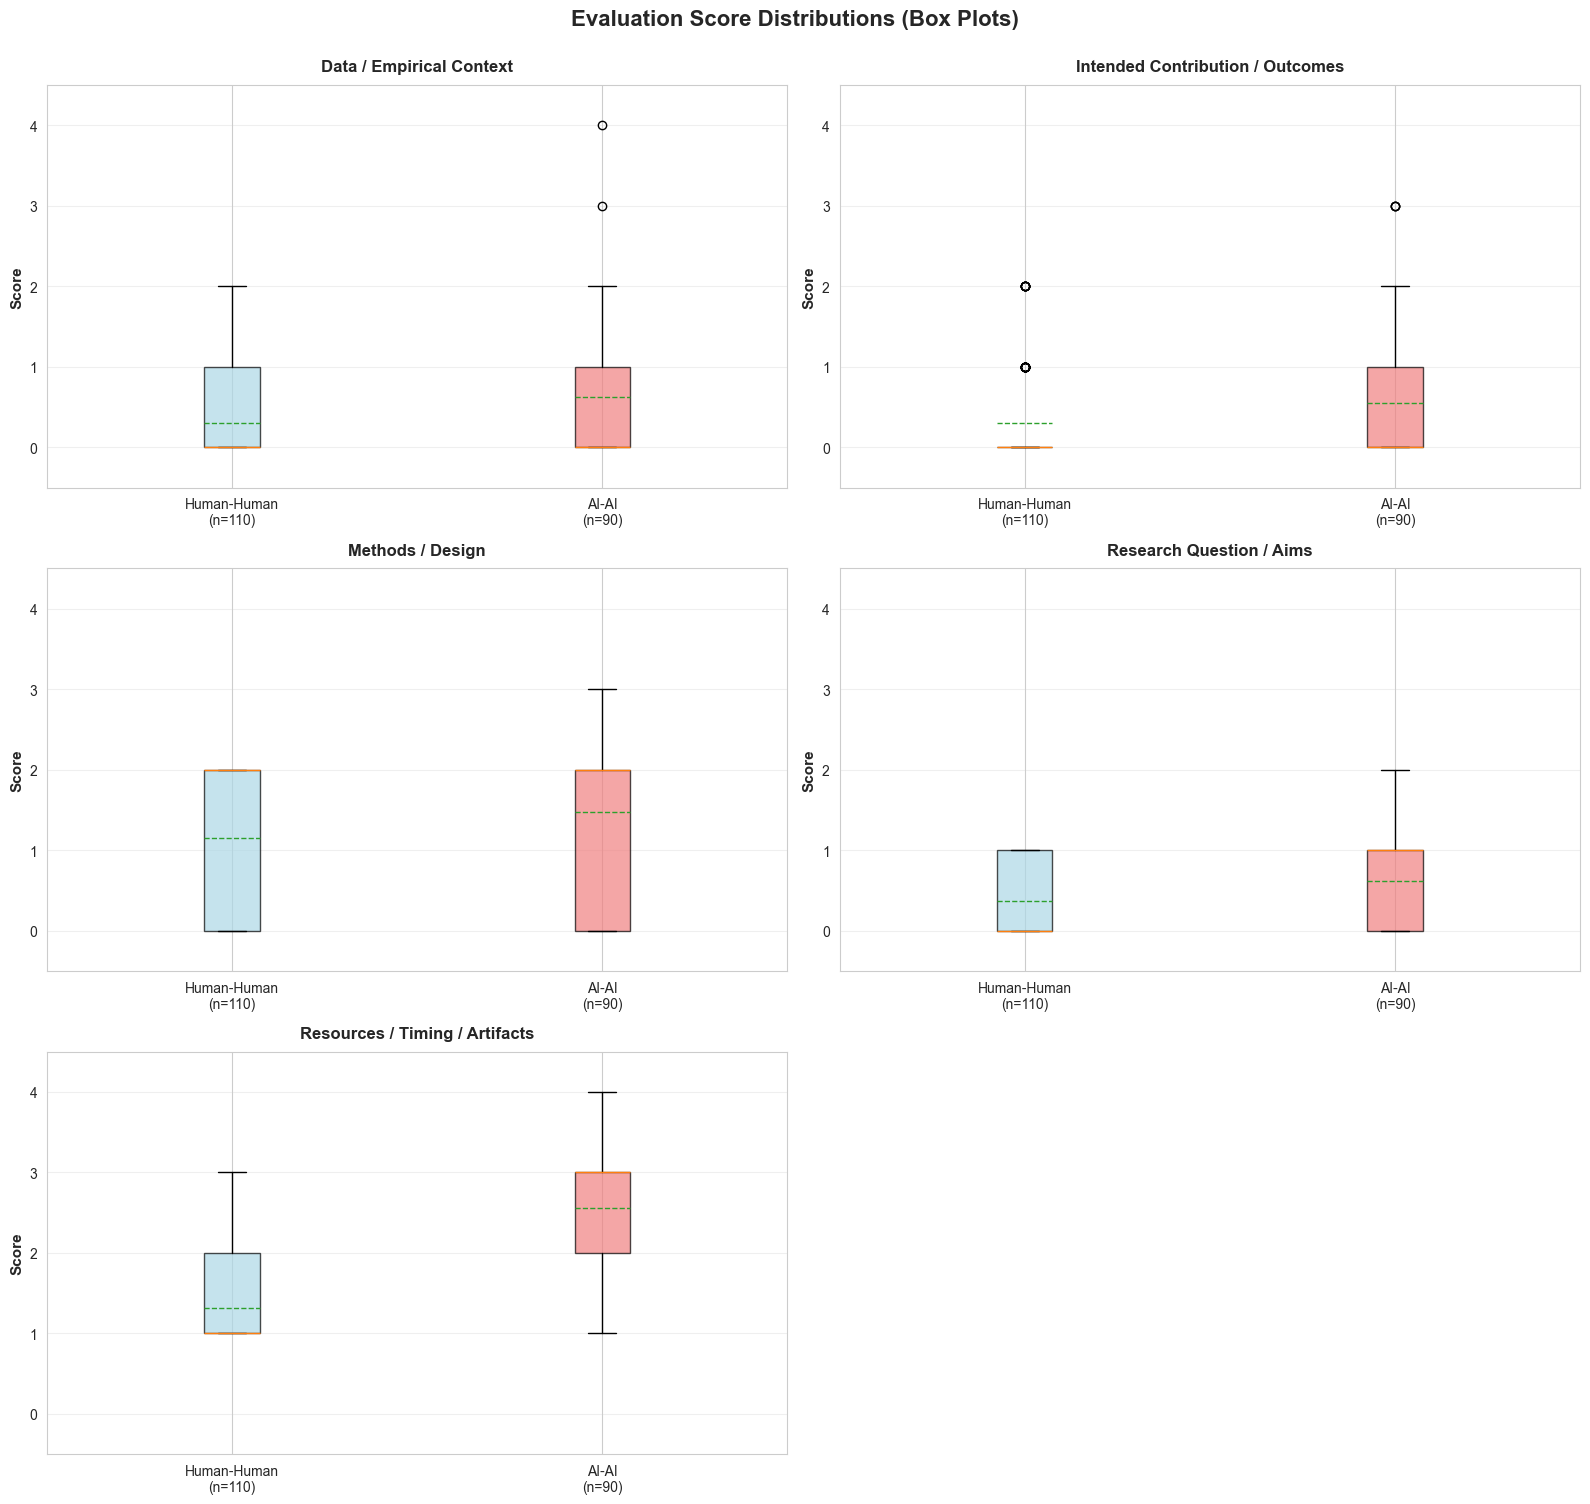

Box plot comparison saved!


In [ ]:
# Box plots for comparative analysis
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] if n_cols == 1 else axes.flatten()

for idx, dim_name in enumerate(all_dimensions):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_to_plot = []
    labels = []
    
    for comp_type, comp_scores in all_scores.items():
        if dim_name in comp_scores:
            data_to_plot.append(comp_scores[dim_name])
            labels.append(f'{comp_type}\n(n={len(comp_scores[dim_name])})')
    
    # Create box plot
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, 
                     showmeans=True, meanline=True)
    
    # Color the boxes
    for patch, comp_type in zip(bp['boxes'], all_scores.keys()):
        if dim_name in all_scores[comp_type]:
            patch.set_facecolor(colors.get(comp_type, 'lightgray'))
            patch.set_alpha(0.7)
    
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(dim_name, fontsize=12, fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(-0.5, 4.5)

# Hide unused subplots
for idx in range(len(all_dimensions), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Evaluation Score Distributions (Box Plots)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
# plt.savefig('evaluations/score_boxplots_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:


print("="*80)
print("STATISTICAL COMPARISON (Mann-Whitney U Test)")
print("="*80)

# Get all comparison type pairs
comp_types = list(all_scores.keys())

if len(comp_types) >= 2:
    for dim_name in all_dimensions:
        print(f"\n{dim_name}:")
        
        # Compare all pairs
        for i, comp_type1 in enumerate(comp_types):
            for comp_type2 in comp_types[i+1:]:
                if dim_name in all_scores[comp_type1] and dim_name in all_scores[comp_type2]:
                    scores1 = all_scores[comp_type1][dim_name]
                    scores2 = all_scores[comp_type2][dim_name]
                    
                    # Perform Mann-Whitney U test
                    statistic, p_value = stats.mannwhitneyu(scores1, scores2, alternative='two-sided')
                    
                    mean1 = np.mean(scores1)
                    mean2 = np.mean(scores2)
                    diff = mean1 - mean2
                    
                    sig_marker = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    
                    print(f"  {comp_type1} vs {comp_type2}:")
                    print(f"    Means: {mean1:.3f} vs {mean2:.3f} (diff: {diff:+.3f})")
                    print(f"    p-value: {p_value:.4f} {sig_marker}")
else:
    print("\nNeed at least 2 comparison types for statistical testing.")
    print("Add more evaluation files to the 'evaluation_files' dictionary above.")

print("\n" + "="*80)
print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("="*80)


STATISTICAL COMPARISON (Mann-Whitney U Test)

Data / Empirical Context:
  Human-Human vs AI-AI:
    Means: 0.300 vs 0.622 (diff: -0.322)
    p-value: 0.0121 *

Intended Contribution / Outcomes:
  Human-Human vs AI-AI:
    Means: 0.300 vs 0.544 (diff: -0.244)
    p-value: 0.1038 ns

Methods / Design:
  Human-Human vs AI-AI:
    Means: 1.155 vs 1.478 (diff: -0.323)
    p-value: 0.0114 *

Research Question / Aims:
  Human-Human vs AI-AI:
    Means: 0.373 vs 0.611 (diff: -0.238)
    p-value: 0.0017 **

Resources / Timing / Artifacts:
  Human-Human vs AI-AI:
    Means: 1.309 vs 2.556 (diff: -1.246)
    p-value: 0.0000 ***

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


### Semantic similarity 

#### baseline (human-human vs AI all models, without giving previous ideas)

In [13]:
# Define paths to similarity files for comparison
similarity_files = {
    'Human': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_human-human/similarity_human-human_20251107_103532.json',
    'Gemini': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_ai-ai_generate_ideas_no_role_genby_gemini/similarity_ai-ai_generate_ideas_no_role_genby_gemini_20251107_112928.json',
    # Add your other similarity files here:
    'Claude': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_ai-ai_generate_ideas_no_role_genby_claude/similarity_ai-ai_generate_ideas_no_role_genby_claude_20251107_113735.json',
    'GPT-4': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_ai-ai_generate_ideas_no_role_genby_gpt/similarity_ai-ai_generate_ideas_no_role_genby_gpt_20251107_112906.json',
    'Grok': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_ai-ai_generate_ideas_no_role_genby_grok/similarity_ai-ai_generate_ideas_no_role_genby_grok_20251107_112837.json',
    
}

print("Similarity files to compare:")
for comp_type, path in similarity_files.items():
    if Path(path).exists():
        print(f"  {comp_type}: {Path(path).name}")
        print(f"    Exists: ✓")
    else:
        print(f"  {comp_type}: NOT FOUND")


Similarity files to compare:
  Human: similarity_human-human_20251107_103532.json
    Exists: ✓
  Gemini: similarity_ai-ai_generate_ideas_no_role_genby_gemini_20251107_112928.json
    Exists: ✓
  Claude: similarity_ai-ai_generate_ideas_no_role_genby_claude_20251107_113735.json
    Exists: ✓
  GPT-4: similarity_ai-ai_generate_ideas_no_role_genby_gpt_20251107_112906.json
    Exists: ✓
  Grok: similarity_ai-ai_generate_ideas_no_role_genby_grok_20251107_112837.json
    Exists: ✓


In [14]:
# Load and extract similarity metrics from all JSON files
def extract_similarity_metrics(sim_file_path):
    """Extract all similarity metrics from a similarity JSON file"""
    with open(sim_file_path, 'r') as f:
        data = json.load(f)
    
    results = data['results']
    
    # Dictionary to store metrics
    metrics = {
        'tfidf_cosine_similarity': [],
        'embedding_cosine_similarity': [],
        'keyword_jaccard': [],
        'topic_lda_cosine': []
    }
    
    for result in results:
        
        if 'similarity_metrics' not in result.keys():
            continue

        sim_metrics = result['similarity_metrics']
        
        # Extract metrics safely
        tfidf_val = sim_metrics.get('tfidf_cosine_similarity')
        metrics['tfidf_cosine_similarity'].append(tfidf_val if isinstance(tfidf_val, (int, float)) else np.nan)
        
        emb_val = sim_metrics.get('embedding_cosine_similarity')
        metrics['embedding_cosine_similarity'].append(emb_val if isinstance(emb_val, (int, float)) else np.nan)
        
        # Extract keyword jaccard
        keyword_overlap = sim_metrics.get('keyword_overlap', {})
        kw_val = keyword_overlap.get('jaccard_similarity') if isinstance(keyword_overlap, dict) else None
        metrics['keyword_jaccard'].append(kw_val if isinstance(kw_val, (int, float)) else np.nan)
        
        # Extract topic LDA cosine
        topic_overlap = sim_metrics.get('topic_overlap', {})
        topic_val = topic_overlap.get('lda_cosine_similarity') if isinstance(topic_overlap, dict) else None
        metrics['topic_lda_cosine'].append(topic_val if isinstance(topic_val, (int, float)) else np.nan)
    
    return metrics

def is_valid_number(v):
    """Check if value is a valid number (not None, not NaN)"""
    return v is not None and isinstance(v, (int, float)) and not np.isnan(v)

# Extract metrics from all similarity files
all_similarity_metrics = {}
for comp_type, sim_file in similarity_files.items():
    if Path(sim_file).exists():
        all_similarity_metrics[comp_type] = extract_similarity_metrics(sim_file)
        print(f"Loaded {comp_type}:")
        for metric_name, values in all_similarity_metrics[comp_type].items():
            valid_values = [v for v in values if is_valid_number(v)]
            if len(valid_values) > 0:
                print(f"  {metric_name}: {len(valid_values)} values (mean: {np.mean(valid_values):.3f})")
            else:
                print(f"  {metric_name}: 0 valid values")
    else:
        print(f"Warning: {comp_type} file not found!")

print(f"\nTotal comparison types loaded: {len(all_similarity_metrics)}")


Loaded Human:
  tfidf_cosine_similarity: 110 values (mean: 0.159)
  embedding_cosine_similarity: 110 values (mean: 0.732)
  keyword_jaccard: 110 values (mean: 0.065)
  topic_lda_cosine: 0 valid values
Loaded Gemini:
  tfidf_cosine_similarity: 90 values (mean: 0.369)
  embedding_cosine_similarity: 90 values (mean: 0.949)
  keyword_jaccard: 90 values (mean: 0.173)
  topic_lda_cosine: 0 valid values
Loaded Claude:
  tfidf_cosine_similarity: 90 values (mean: 0.350)
  embedding_cosine_similarity: 90 values (mean: 0.948)
  keyword_jaccard: 90 values (mean: 0.160)
  topic_lda_cosine: 0 valid values
Loaded GPT-4:
  tfidf_cosine_similarity: 90 values (mean: 0.236)
  embedding_cosine_similarity: 90 values (mean: 0.743)
  keyword_jaccard: 90 values (mean: 0.141)
  topic_lda_cosine: 0 valid values
Loaded Grok:
  tfidf_cosine_similarity: 90 values (mean: 0.554)
  embedding_cosine_similarity: 90 values (mean: 0.950)
  keyword_jaccard: 90 values (mean: 0.291)
  topic_lda_cosine: 0 valid values

Total

/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_47062/2053250012.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2')  # or 'Pastel1' for even more muted
/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_47062/2053250012.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=9)


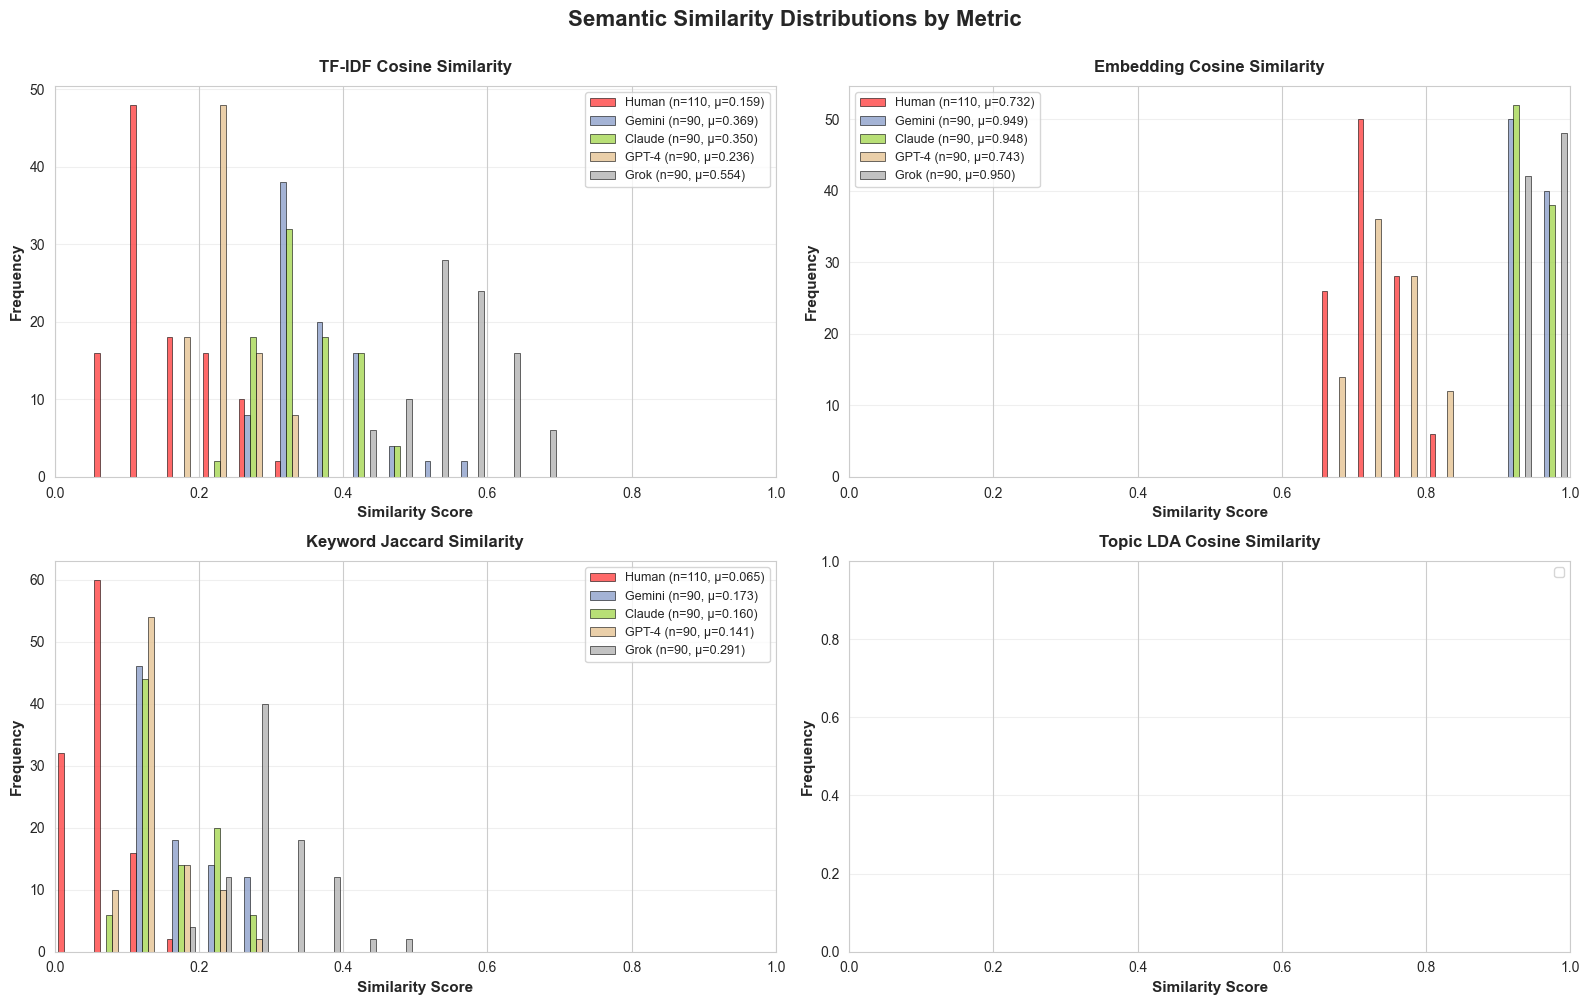

In [20]:
# Automatically generate colors based on comparison types (not metrics)
comp_types_list = list(all_similarity_metrics.keys())
n_comp_types = len(comp_types_list)

# Create color dictionary with human-human standing out
sim_colors = {}
for i, comp_type in enumerate(comp_types_list):
    if 'human' in comp_type.lower():
        # Use a bright, distinctive color for human-human (e.g., red or orange)
        sim_colors[comp_type] = '#FF4444'  # Bright red
        # Or try: '#FF8C00' (dark orange), '#FF1493' (deep pink), '#00CED1' (dark turquoise)
    else:
        # Use muted colors for other comparison types
        cmap = plt.cm.get_cmap('Set2')  # or 'Pastel1' for even more muted
        sim_colors[comp_type] = cmap(i / max(n_comp_types - 1, 1))

# Create combined histogram plot for all metrics with side-by-side bars
n_metrics = len(all_sim_metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] if n_cols == 1 else axes.flatten()

# Number of bins for histograms (0 to 1)
n_bins = 20

for idx, metric in enumerate(all_sim_metrics):
    ax = axes[idx]
    
    # Get comparison types that have this metric
    comp_types_with_metric = [ct for ct in all_similarity_metrics.keys()]
    n_comp_types = len(comp_types_with_metric)
    
    # Calculate bar width
    bin_width = 1.0 / n_bins
    bar_width = bin_width / n_comp_types * 0.8
    
    # Plot bars for each comparison type (side-by-side)
    for i, comp_type in enumerate(comp_types_with_metric):
        values = all_similarity_metrics[comp_type][metric]
        valid_values = [v for v in values if is_valid_number(v)]
        
        if len(valid_values) > 0:
            # Create histogram bins
            counts, bin_edges = np.histogram(valid_values, bins=n_bins, range=(0, 1))
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Calculate x positions (offset for each comparison type)
            x_positions = bin_centers + (i - n_comp_types/2 + 0.5) * bar_width
            
            ax.bar(x_positions, counts, width=bar_width,
                   label=f'{comp_type} (n={len(valid_values)}, μ={np.mean(valid_values):.3f})',
                   color=sim_colors.get(comp_type, 'gray'),
                   edgecolor='black', linewidth=0.5, alpha=0.8)
    
    ax.set_xlabel('Similarity Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(sim_metric_names[metric], fontsize=12, fontweight='bold', pad=10)
    
    # Move legend to upper left for embedding similarity, keep upper right for others
    if 'embedding' in metric.lower():
        ax.legend(loc='upper left', fontsize=9)
    else:
        ax.legend(loc='upper right', fontsize=9)
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_xlim(0, 1)

# Hide unused subplots
for idx in range(len(all_sim_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Semantic Similarity Distributions by Metric', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


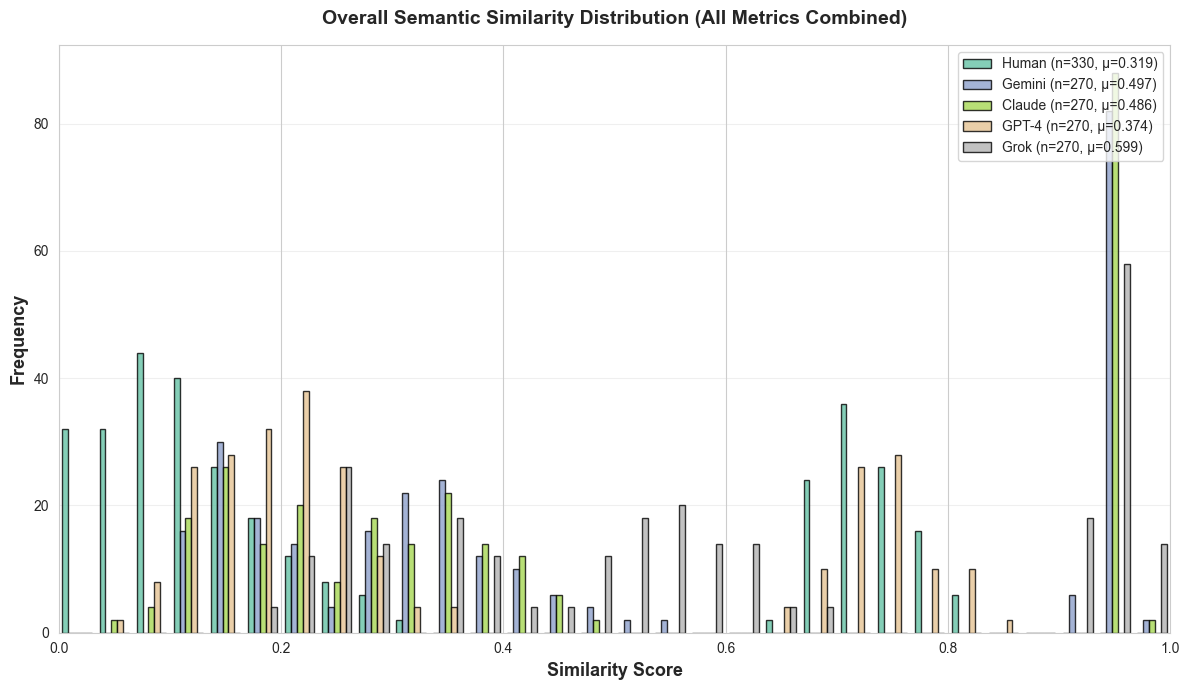

In [16]:
# Create overall similarity distribution (all metrics combined)
fig, ax = plt.subplots(figsize=(12, 7))

# Number of bins
n_bins = 30

# Get all comparison types
comp_types_list = list(all_similarity_metrics.keys())
n_comp_types = len(comp_types_list)
bin_width = 1.0 / n_bins
bar_width = bin_width / n_comp_types * 0.8

# Plot bars for each comparison type (side-by-side)
for i, comp_type in enumerate(comp_types_list):
    comp_metrics = all_similarity_metrics[comp_type]
    
    # Combine all metrics
    all_comp_values = []
    for metric_values in comp_metrics.values():
        all_comp_values.extend([v for v in metric_values if is_valid_number(v)])
    
    if len(all_comp_values) > 0:
        # Create histogram bins
        counts, bin_edges = np.histogram(all_comp_values, bins=n_bins, range=(0, 1))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Calculate x positions (offset for each comparison type)
        x_positions = bin_centers + (i - n_comp_types/2 + 0.5) * bar_width
        
        ax.bar(x_positions, counts, width=bar_width,
               label=f'{comp_type} (n={len(all_comp_values)}, μ={np.mean(all_comp_values):.3f})',
               color=sim_colors.get(comp_type, 'gray'),
               edgecolor='black', linewidth=1, alpha=0.8)

ax.set_xlabel('Similarity Score', fontsize=13, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax.set_title('Overall Semantic Similarity Distribution (All Metrics Combined)', 
            fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
#plt.savefig('semantic_similarity/overall_similarity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

#print("Overall similarity distribution saved!")


In [ ]:
# Comparative summary statistics for similarity metrics
print("="*80)
print("SEMANTIC SIMILARITY COMPARATIVE STATISTICS") 
print("="*80)

for comp_type, comp_metrics in all_similarity_metrics.items():
    print(f"\n{'='*80}")
    print(f"{comp_type.upper()}")
    print("="*80)
    
    # Overall statistics (all metrics combined)
    all_comp_values = []
    for metric_values in comp_metrics.values():
        all_comp_values.extend([v for v in metric_values if is_valid_number(v)])
    
    print(f"\nOverall (All Metrics Combined):")
    print(f"  Total values: {len(all_comp_values)}")
    print(f"  Mean: {np.mean(all_comp_values):.4f}")
    print(f"  Median: {np.median(all_comp_values):.4f}")
    print(f"  Std Dev: {np.std(all_comp_values):.4f}")
    print(f"  Min: {np.min(all_comp_values):.4f}, Max: {np.max(all_comp_values):.4f}")
    print(f"  Range: {np.max(all_comp_values) - np.min(all_comp_values):.4f}")
    
    # Quartiles
    q25, q50, q75 = np.percentile(all_comp_values, [25, 50, 75])
    print(f"  Quartiles: Q1={q25:.4f}, Q2={q50:.4f}, Q3={q75:.4f}")
    
    # Per-metric statistics
    print(f"\nBy Metric:")
    for metric_name in all_sim_metrics:
        metric_values = comp_metrics[metric_name]
        valid_values = [v for v in metric_values if is_valid_number(v)]
        if len(valid_values) > 0:
            mean_val = np.mean(valid_values)
            median_val = np.median(valid_values)
            print(f"  {sim_metric_names[metric_name]}:")
            print(f"    Mean: {mean_val:.4f}, Median: {median_val:.4f}, n={len(valid_values)}")

print("\n" + "="*80)


SEMANTIC SIMILARITY COMPARATIVE STATISTICS

HUMAN

Overall (All Metrics Combined):
  Total values: 330
  Mean: 0.3190
  Median: 0.1453
  Std Dev: 0.2986
  Min: 0.0256, Max: 0.8314
  Range: 0.8057
  Quartiles: Q1=0.0811, Q2=0.1453, Q3=0.7032

By Metric:
  TF-IDF Cosine Similarity:
    Mean: 0.1594, Median: 0.1449, n=110
  Embedding Cosine Similarity:
    Mean: 0.7325, Median: 0.7303, n=110
  Keyword Jaccard Similarity:
    Mean: 0.0650, Median: 0.0526, n=110

GEMINI

Overall (All Metrics Combined):
  Total values: 270
  Mean: 0.4968
  Median: 0.3490
  Std Dev: 0.3330
  Min: 0.1111, Max: 0.9669
  Range: 0.8558
  Quartiles: Q1=0.2121, Q2=0.3490, Q3=0.9404

By Metric:
  TF-IDF Cosine Similarity:
    Mean: 0.3689, Median: 0.3490, n=90
  Embedding Cosine Similarity:
    Mean: 0.9489, Median: 0.9494, n=90
  Keyword Jaccard Similarity:
    Mean: 0.1726, Median: 0.1429, n=90

CLAUDE

Overall (All Metrics Combined):
  Total values: 270
  Mean: 0.4863
  Median: 0.3474
  Std Dev: 0.3387
  Min: 0.0

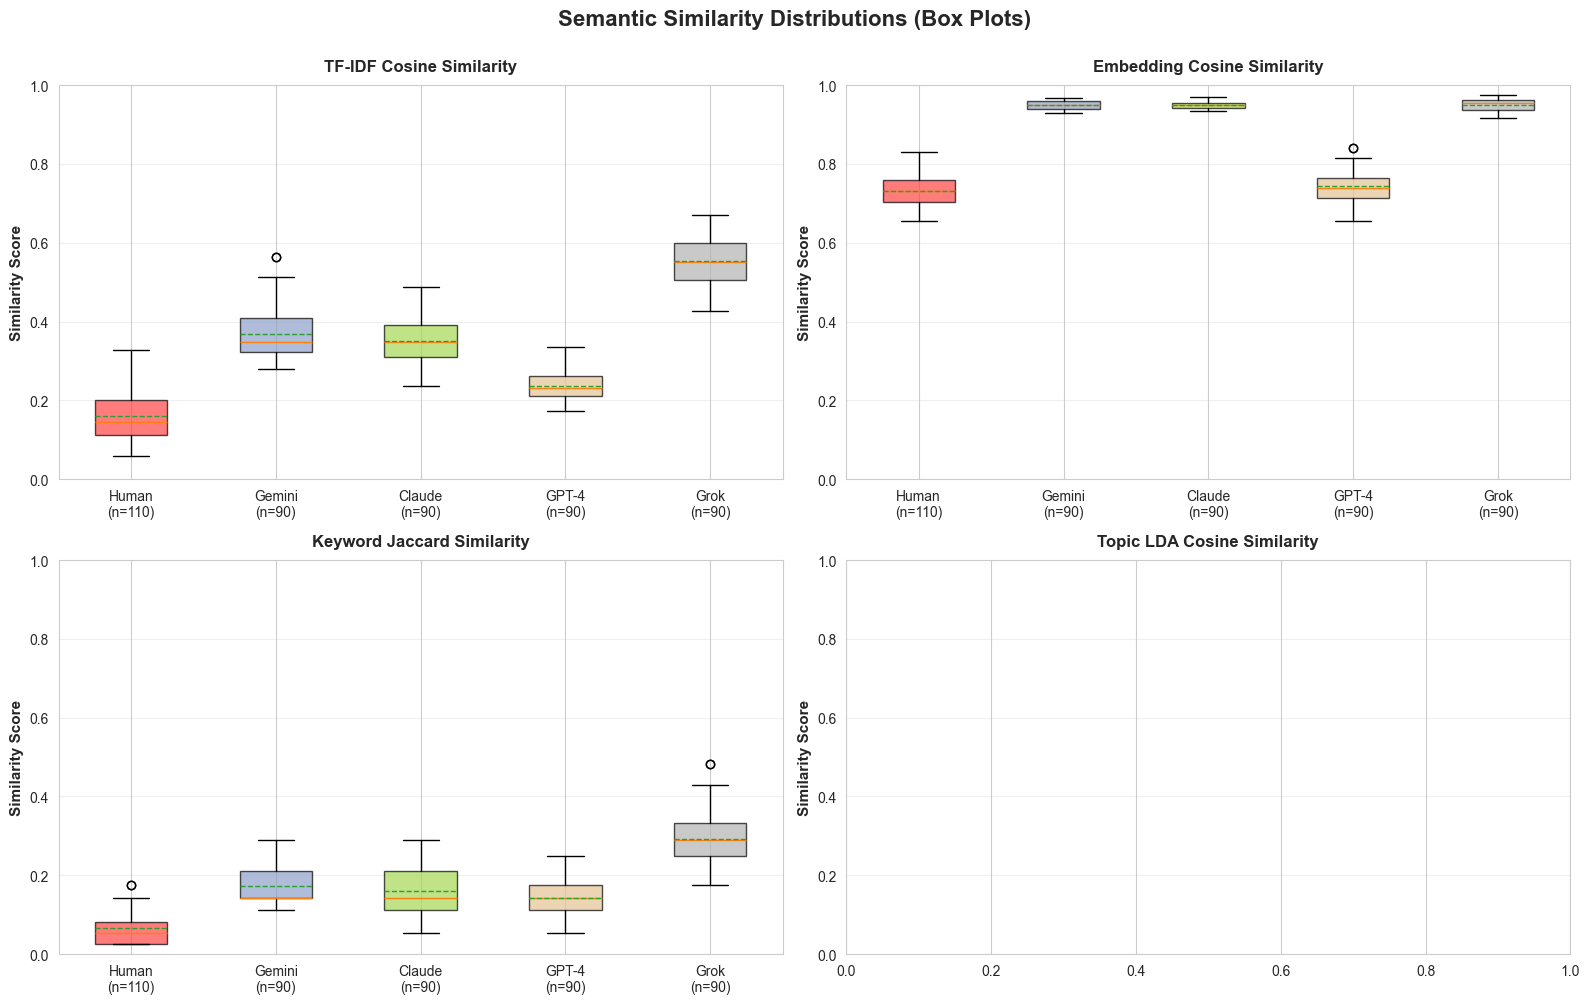

Box plot comparison saved!


In [22]:
# Box plots for comparative similarity analysis
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] if n_cols == 1 else axes.flatten()

for idx, metric in enumerate(all_sim_metrics):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_to_plot = []
    labels = []
    
    for comp_type in all_similarity_metrics.keys():
        metric_values = all_similarity_metrics[comp_type][metric]
        valid_values = [v for v in metric_values if is_valid_number(v)]
        if len(valid_values) > 0:
            data_to_plot.append(valid_values)
            labels.append(f'{comp_type}\n(n={len(valid_values)})')
    
    if len(data_to_plot) > 0:
        # Create box plot
        bp = ax.boxplot(data_to_plot, tick_labels=labels, patch_artist=True,
                         showmeans=True, meanline=True)
        
        # Color the boxes
        for patch_idx, comp_type in enumerate(all_similarity_metrics.keys()):
            bp['boxes'][patch_idx].set_facecolor(sim_colors.get(comp_type, 'lightgray'))
            bp['boxes'][patch_idx].set_alpha(0.7)
    
    ax.set_ylabel('Similarity Score', fontsize=11, fontweight='bold')
    ax.set_title(sim_metric_names[metric], fontsize=12, fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)

# Hide unused subplots
for idx in range(len(all_sim_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Semantic Similarity Distributions (Box Plots)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
#plt.savefig('semantic_similarity/similarity_boxplots_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Box plot comparison saved!")


In [ ]:
# Statistical comparison between comparison types for similarity metrics
print("="*80)
print("STATISTICAL COMPARISON (Mann-Whitney U Test) - Similarity Metrics")
print("="*80)

# Get all comparison type pairs
sim_comp_types = list(all_similarity_metrics.keys())

if len(sim_comp_types) >= 2:
    for metric in all_sim_metrics:
        print(f"\n{sim_metric_names[metric]}:")
        
        # Compare all pairs
        for i, comp_type1 in enumerate(sim_comp_types):
            for comp_type2 in enumerate(sim_comp_types[i+1:], start=i+1):
                comp_type2_name = sim_comp_types[comp_type2[0]]
                
                values1 = all_similarity_metrics[comp_type1][metric]
                values2 = all_similarity_metrics[comp_type2_name][metric]
                
                valid_values1 = [v for v in values1 if is_valid_number(v)]
                valid_values2 = [v for v in values2 if is_valid_number(v)]
                
                if len(valid_values1) > 0 and len(valid_values2) > 0:
                    # Perform Mann-Whitney U test
                    statistic, p_value = stats.mannwhitneyu(valid_values1, valid_values2, alternative='two-sided')
                    
                    mean1 = np.mean(valid_values1)
                    mean2 = np.mean(valid_values2)
                    diff = mean1 - mean2
                    
                    # Effect size (Cohen's d)
                    pooled_std = np.sqrt((np.std(valid_values1)**2 + np.std(valid_values2)**2) / 2)
                    cohens_d = diff / pooled_std if pooled_std > 0 else 0
                    
                    sig_marker = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    
                    print(f"  {comp_type1} vs {comp_type2_name}:")
                    print(f"    Means: {mean1:.4f} vs {mean2:.4f} (diff: {diff:+.4f})")
                    print(f"    p-value: {p_value:.4f} {sig_marker}")
                    print(f"    Cohen's d: {cohens_d:.3f}")
else:
    print("\nNeed at least 2 comparison types for statistical testing.")
    print("Add more similarity files to the 'similarity_files' dictionary above.")

print("\n" + "="*80)
print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("="*80)


STATISTICAL COMPARISON (Mann-Whitney U Test) - Similarity Metrics

TF-IDF Cosine Similarity:
  Human vs Gemini:
    Means: 0.1594 vs 0.3689 (diff: -0.2094)
    p-value: 0.0000 ***
    Cohen's d: -3.368
  Human vs Claude:
    Means: 0.1594 vs 0.3502 (diff: -0.1907)
    p-value: 0.0000 ***
    Cohen's d: -3.180
  Human vs GPT-4:
    Means: 0.1594 vs 0.2361 (diff: -0.0766)
    p-value: 0.0000 ***
    Cohen's d: -1.468
  Human vs Grok:
    Means: 0.1594 vs 0.5545 (diff: -0.3950)
    p-value: 0.0000 ***
    Cohen's d: -6.439
  Gemini vs Claude:
    Means: 0.3689 vs 0.3502 (diff: +0.0187)
    p-value: 0.1107 ns
    Cohen's d: 0.312
  Gemini vs GPT-4:
    Means: 0.3689 vs 0.2361 (diff: +0.1328)
    p-value: 0.0000 ***
    Cohen's d: 2.550
  Gemini vs Grok:
    Means: 0.3689 vs 0.5545 (diff: -0.1856)
    p-value: 0.0000 ***
    Cohen's d: -3.029
  Claude vs GPT-4:
    Means: 0.3502 vs 0.2361 (diff: +0.1141)
    p-value: 0.0000 ***
    Cohen's d: 2.308
  Claude vs Grok:
    Means: 0.3502 vs 0.5

### Human vs AI diverse idea condition (human 11 proposals, AI each 30 ideas)

In [26]:
# Define paths to similarity files for comparison
similarity_files = {
    'Human': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_human-human/similarity_human-human_20251107_103532.json',
    'Gemini':  '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_ai-ai_genby_gemini/similarity_ai-ai_genby_gemini_20251107_103723.json',
    'Claude': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_ai-ai_genby_claude/similarity_ai-ai_genby_claude_20251109_150536.json',
    'GPT-4': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_ai-ai_genby_claude/similarity_ai-ai_genby_claude_20251109_150536.json',
    'Grok': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_ai-ai_genby_grok/similarity_ai-ai_genby_grok_20251107_104653.json',
}

print("Similarity files to compare:")
for comp_type, path in similarity_files.items():
    if Path(path).exists():
        print(f"  {comp_type}: {Path(path).name}")
        print(f"    Exists: ✓")
    else:
        print(f"  {comp_type}: NOT FOUND")


Similarity files to compare:
  Human: similarity_human-human_20251107_103532.json
    Exists: ✓
  Gemini: similarity_ai-ai_genby_gemini_20251107_103723.json
    Exists: ✓
  Claude: similarity_ai-ai_genby_claude_20251109_150536.json
    Exists: ✓
  GPT-4: similarity_ai-ai_genby_claude_20251109_150536.json
    Exists: ✓
  Grok: similarity_ai-ai_genby_grok_20251107_104653.json
    Exists: ✓


In [27]:
# Load and extract similarity metrics from all JSON files
def extract_similarity_metrics(sim_file_path):
    """Extract all similarity metrics from a similarity JSON file"""
    with open(sim_file_path, 'r') as f:
        data = json.load(f)
    
    results = data['results']
    
    # Dictionary to store metrics
    metrics = {
        'tfidf_cosine_similarity': [],
        'embedding_cosine_similarity': [],
        'keyword_jaccard': [],
        'topic_lda_cosine': []
    }
    
    for result in results:
        
        if 'similarity_metrics' not in result.keys():
            continue

        sim_metrics = result['similarity_metrics']
        
        # Extract metrics safely
        tfidf_val = sim_metrics.get('tfidf_cosine_similarity')
        metrics['tfidf_cosine_similarity'].append(tfidf_val if isinstance(tfidf_val, (int, float)) else np.nan)
        
        emb_val = sim_metrics.get('embedding_cosine_similarity')
        metrics['embedding_cosine_similarity'].append(emb_val if isinstance(emb_val, (int, float)) else np.nan)
        
        # Extract keyword jaccard
        keyword_overlap = sim_metrics.get('keyword_overlap', {})
        kw_val = keyword_overlap.get('jaccard_similarity') if isinstance(keyword_overlap, dict) else None
        metrics['keyword_jaccard'].append(kw_val if isinstance(kw_val, (int, float)) else np.nan)
        
        # Extract topic LDA cosine
        topic_overlap = sim_metrics.get('topic_overlap', {})
        topic_val = topic_overlap.get('lda_cosine_similarity') if isinstance(topic_overlap, dict) else None
        metrics['topic_lda_cosine'].append(topic_val if isinstance(topic_val, (int, float)) else np.nan)
    
    return metrics

def is_valid_number(v):
    """Check if value is a valid number (not None, not NaN)"""
    return v is not None and isinstance(v, (int, float)) and not np.isnan(v)

# Extract metrics from all similarity files
all_similarity_metrics = {}
for comp_type, sim_file in similarity_files.items():
    if Path(sim_file).exists():
        all_similarity_metrics[comp_type] = extract_similarity_metrics(sim_file)
        print(f"Loaded {comp_type}:")
        for metric_name, values in all_similarity_metrics[comp_type].items():
            valid_values = [v for v in values if is_valid_number(v)]
            if len(valid_values) > 0:
                print(f"  {metric_name}: {len(valid_values)} values (mean: {np.mean(valid_values):.3f})")
            else:
                print(f"  {metric_name}: 0 valid values")
    else:
        print(f"Warning: {comp_type} file not found!")

print(f"\nTotal comparison types loaded: {len(all_similarity_metrics)}")


Loaded Human:
  tfidf_cosine_similarity: 110 values (mean: 0.159)
  embedding_cosine_similarity: 110 values (mean: 0.732)
  keyword_jaccard: 110 values (mean: 0.065)
  topic_lda_cosine: 0 valid values
Loaded Gemini:
  tfidf_cosine_similarity: 870 values (mean: 0.394)
  embedding_cosine_similarity: 870 values (mean: 0.948)
  keyword_jaccard: 870 values (mean: 0.181)
  topic_lda_cosine: 0 valid values
Loaded Claude:
  tfidf_cosine_similarity: 870 values (mean: 0.331)
  embedding_cosine_similarity: 870 values (mean: 0.941)
  keyword_jaccard: 870 values (mean: 0.186)
  topic_lda_cosine: 0 valid values
Loaded GPT-4:
  tfidf_cosine_similarity: 870 values (mean: 0.331)
  embedding_cosine_similarity: 870 values (mean: 0.941)
  keyword_jaccard: 870 values (mean: 0.186)
  topic_lda_cosine: 0 valid values
Loaded Grok:
  tfidf_cosine_similarity: 870 values (mean: 0.481)
  embedding_cosine_similarity: 870 values (mean: 0.942)
  keyword_jaccard: 870 values (mean: 0.266)
  topic_lda_cosine: 0 valid v

/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_47062/2053250012.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2')  # or 'Pastel1' for even more muted
/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_47062/2053250012.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=9)


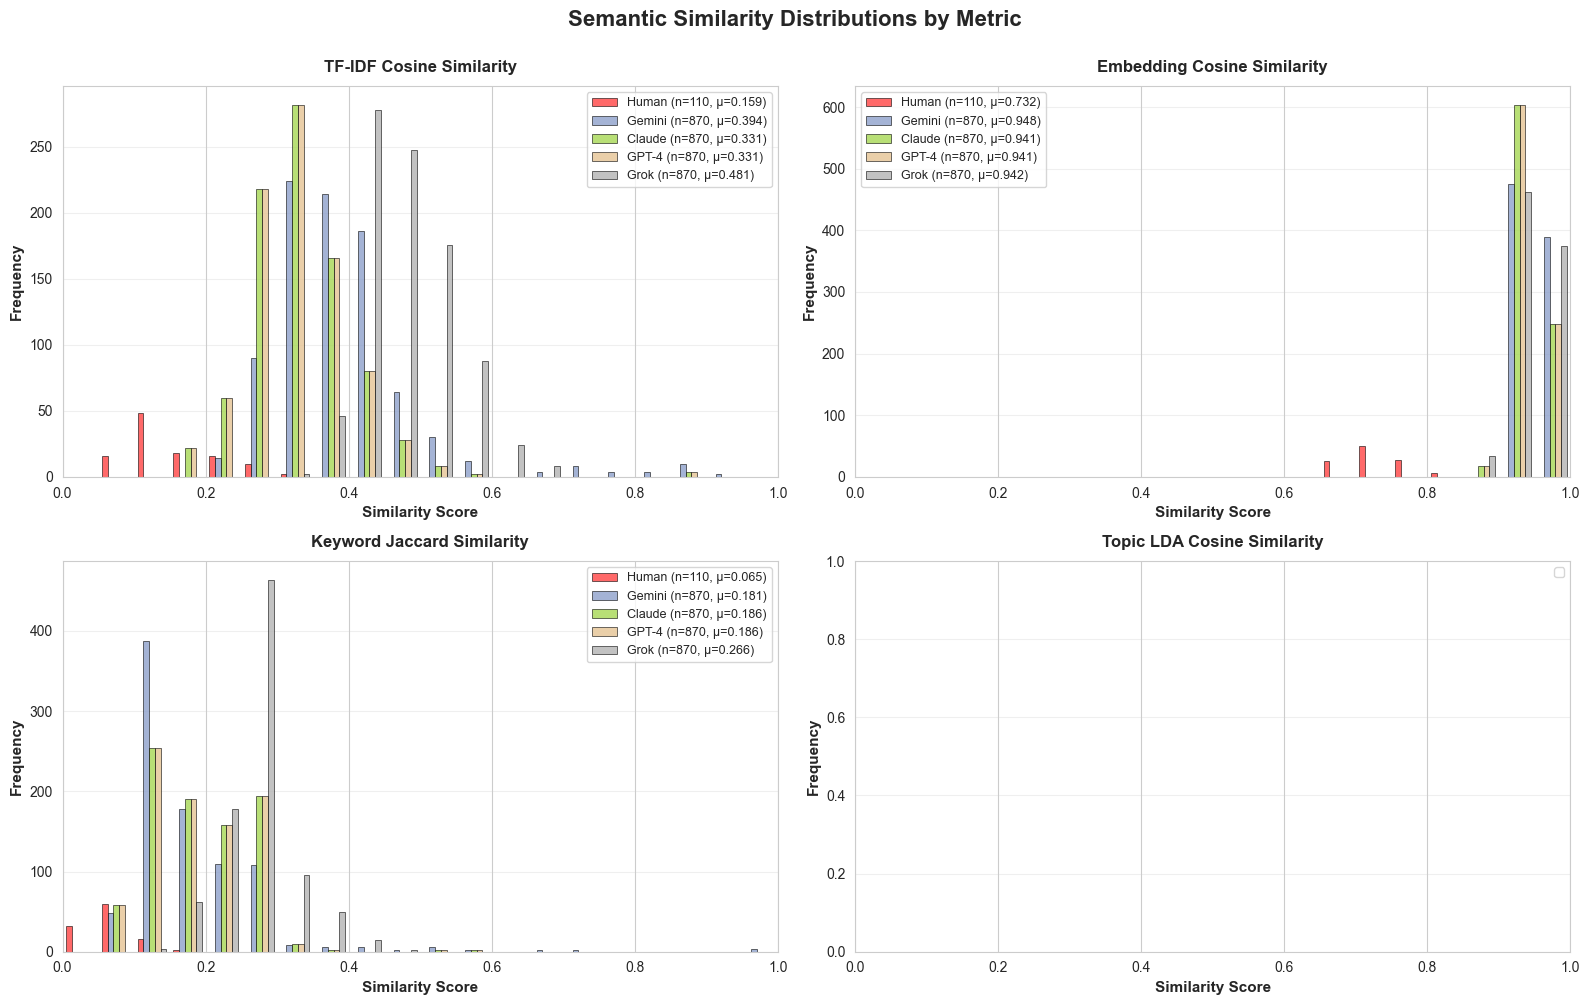

In [28]:
# Automatically generate colors based on comparison types (not metrics)
comp_types_list = list(all_similarity_metrics.keys())
n_comp_types = len(comp_types_list)

# Create color dictionary with human-human standing out
sim_colors = {}
for i, comp_type in enumerate(comp_types_list):
    if 'human' in comp_type.lower():
        # Use a bright, distinctive color for human-human (e.g., red or orange)
        sim_colors[comp_type] = '#FF4444'  # Bright red
        # Or try: '#FF8C00' (dark orange), '#FF1493' (deep pink), '#00CED1' (dark turquoise)
    else:
        # Use muted colors for other comparison types
        cmap = plt.cm.get_cmap('Set2')  # or 'Pastel1' for even more muted
        sim_colors[comp_type] = cmap(i / max(n_comp_types - 1, 1))

# Create combined histogram plot for all metrics with side-by-side bars
n_metrics = len(all_sim_metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] if n_cols == 1 else axes.flatten()

# Number of bins for histograms (0 to 1)
n_bins = 20

for idx, metric in enumerate(all_sim_metrics):
    ax = axes[idx]
    
    # Get comparison types that have this metric
    comp_types_with_metric = [ct for ct in all_similarity_metrics.keys()]
    n_comp_types = len(comp_types_with_metric)
    
    # Calculate bar width
    bin_width = 1.0 / n_bins
    bar_width = bin_width / n_comp_types * 0.8
    
    # Plot bars for each comparison type (side-by-side)
    for i, comp_type in enumerate(comp_types_with_metric):
        values = all_similarity_metrics[comp_type][metric]
        valid_values = [v for v in values if is_valid_number(v)]
        
        if len(valid_values) > 0:
            # Create histogram bins
            counts, bin_edges = np.histogram(valid_values, bins=n_bins, range=(0, 1))
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Calculate x positions (offset for each comparison type)
            x_positions = bin_centers + (i - n_comp_types/2 + 0.5) * bar_width
            
            ax.bar(x_positions, counts, width=bar_width,
                   label=f'{comp_type} (n={len(valid_values)}, μ={np.mean(valid_values):.3f})',
                   color=sim_colors.get(comp_type, 'gray'),
                   edgecolor='black', linewidth=0.5, alpha=0.8)
    
    ax.set_xlabel('Similarity Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(sim_metric_names[metric], fontsize=12, fontweight='bold', pad=10)
    
    # Move legend to upper left for embedding similarity, keep upper right for others
    if 'embedding' in metric.lower():
        ax.legend(loc='upper left', fontsize=9)
    else:
        ax.legend(loc='upper right', fontsize=9)
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_xlim(0, 1)

# Hide unused subplots
for idx in range(len(all_sim_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Semantic Similarity Distributions by Metric', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


In [29]:
# Comparative summary statistics for similarity metrics
print("="*80)
print("SEMANTIC SIMILARITY COMPARATIVE STATISTICS") 
print("="*80)

for comp_type, comp_metrics in all_similarity_metrics.items():
    print(f"\n{'='*80}")
    print(f"{comp_type.upper()}")
    print("="*80)
    
    # Overall statistics (all metrics combined)
    all_comp_values = []
    for metric_values in comp_metrics.values():
        all_comp_values.extend([v for v in metric_values if is_valid_number(v)])
    
    print(f"\nOverall (All Metrics Combined):")
    print(f"  Total values: {len(all_comp_values)}")
    print(f"  Mean: {np.mean(all_comp_values):.4f}")
    print(f"  Median: {np.median(all_comp_values):.4f}")
    print(f"  Std Dev: {np.std(all_comp_values):.4f}")
    print(f"  Min: {np.min(all_comp_values):.4f}, Max: {np.max(all_comp_values):.4f}")
    print(f"  Range: {np.max(all_comp_values) - np.min(all_comp_values):.4f}")
    
    # Quartiles
    q25, q50, q75 = np.percentile(all_comp_values, [25, 50, 75])
    print(f"  Quartiles: Q1={q25:.4f}, Q2={q50:.4f}, Q3={q75:.4f}")
    
    # Per-metric statistics
    print(f"\nBy Metric:")
    for metric_name in all_sim_metrics:
        metric_values = comp_metrics[metric_name]
        valid_values = [v for v in metric_values if is_valid_number(v)]
        if len(valid_values) > 0:
            mean_val = np.mean(valid_values)
            median_val = np.median(valid_values)
            print(f"  {sim_metric_names[metric_name]}:")
            print(f"    Mean: {mean_val:.4f}, Median: {median_val:.4f}, n={len(valid_values)}")

print("\n" + "="*80)


SEMANTIC SIMILARITY COMPARATIVE STATISTICS

HUMAN

Overall (All Metrics Combined):
  Total values: 330
  Mean: 0.3190
  Median: 0.1453
  Std Dev: 0.2986
  Min: 0.0256, Max: 0.8314
  Range: 0.8057
  Quartiles: Q1=0.0811, Q2=0.1453, Q3=0.7032

By Metric:
  TF-IDF Cosine Similarity:
    Mean: 0.1594, Median: 0.1449, n=110
  Embedding Cosine Similarity:
    Mean: 0.7325, Median: 0.7303, n=110
  Keyword Jaccard Similarity:
    Mean: 0.0650, Median: 0.0526, n=110

GEMINI

Overall (All Metrics Combined):
  Total values: 2610
  Mean: 0.5079
  Median: 0.3799
  Std Dev: 0.3344
  Min: 0.0526, Max: 1.0000
  Range: 0.9474
  Quartiles: Q1=0.2121, Q2=0.3799, Q3=0.9399

By Metric:
  TF-IDF Cosine Similarity:
    Mean: 0.3944, Median: 0.3738, n=870
  Embedding Cosine Similarity:
    Mean: 0.9481, Median: 0.9481, n=870
  Keyword Jaccard Similarity:
    Mean: 0.1813, Median: 0.1429, n=870

CLAUDE

Overall (All Metrics Combined):
  Total values: 2610
  Mean: 0.4861
  Median: 0.3250
  Std Dev: 0.3322
  Min

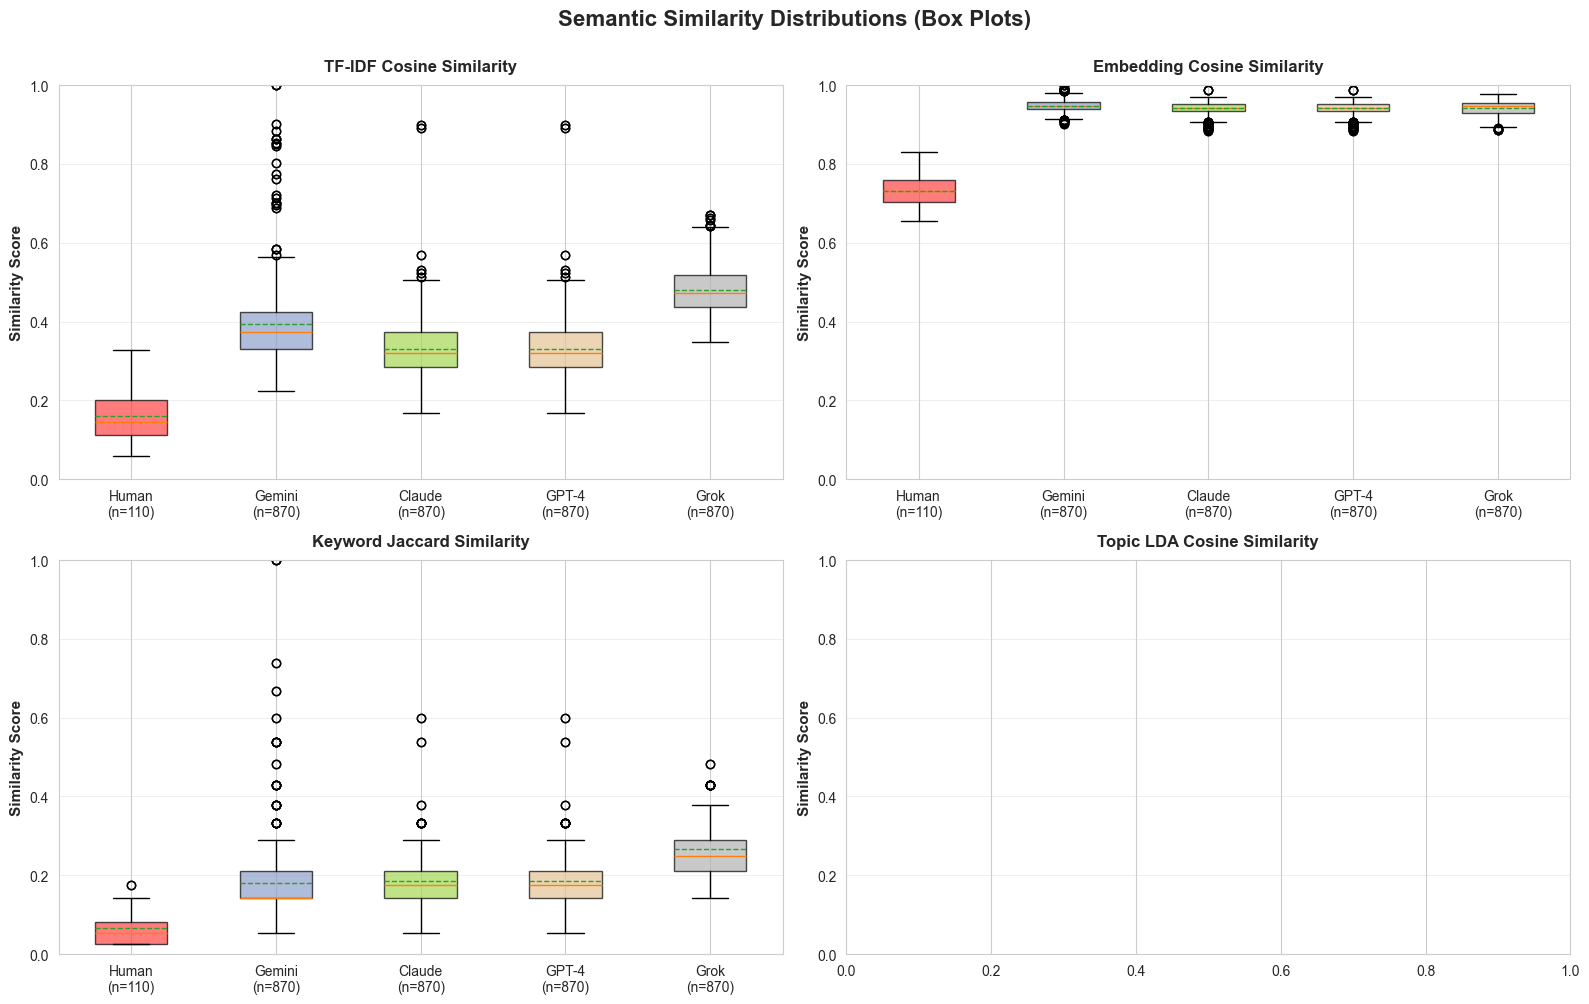

Box plot comparison saved!


In [ ]:
# Box plots for comparative similarity analysis
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] if n_cols == 1 else axes.flatten()

for idx, metric in enumerate(all_sim_metrics):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_to_plot = []
    labels = []
    
    for comp_type in all_similarity_metrics.keys():
        metric_values = all_similarity_metrics[comp_type][metric]
        valid_values = [v for v in metric_values if is_valid_number(v)]
        if len(valid_values) > 0:
            data_to_plot.append(valid_values)
            labels.append(f'{comp_type}\n(n={len(valid_values)})')
    
    if len(data_to_plot) > 0:
        # Create box plot
        bp = ax.boxplot(data_to_plot, tick_labels=labels, patch_artist=True,
                         showmeans=True, meanline=True)
        
        # Color the boxes
        for patch_idx, comp_type in enumerate(all_similarity_metrics.keys()):
            bp['boxes'][patch_idx].set_facecolor(sim_colors.get(comp_type, 'lightgray'))
            bp['boxes'][patch_idx].set_alpha(0.7)
    
    ax.set_ylabel('Similarity Score', fontsize=11, fontweight='bold')
    ax.set_title(sim_metric_names[metric], fontsize=12, fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)

# Hide unused subplots
for idx in range(len(all_sim_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Semantic Similarity Distributions (Box Plots)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
#plt.savefig('semantic_similarity/similarity_boxplots_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



In [31]:
# Statistical comparison between comparison types for similarity metrics
print("="*80)
print("STATISTICAL COMPARISON (Mann-Whitney U Test) - Similarity Metrics")
print("="*80)

# Get all comparison type pairs
sim_comp_types = list(all_similarity_metrics.keys())

if len(sim_comp_types) >= 2:
    for metric in all_sim_metrics:
        print(f"\n{sim_metric_names[metric]}:")
        
        # Compare all pairs
        for i, comp_type1 in enumerate(sim_comp_types):
            for comp_type2 in enumerate(sim_comp_types[i+1:], start=i+1):
                comp_type2_name = sim_comp_types[comp_type2[0]]
                
                values1 = all_similarity_metrics[comp_type1][metric]
                values2 = all_similarity_metrics[comp_type2_name][metric]
                
                valid_values1 = [v for v in values1 if is_valid_number(v)]
                valid_values2 = [v for v in values2 if is_valid_number(v)]
                
                if len(valid_values1) > 0 and len(valid_values2) > 0:
                    # Perform Mann-Whitney U test
                    statistic, p_value = stats.mannwhitneyu(valid_values1, valid_values2, alternative='two-sided')
                    
                    mean1 = np.mean(valid_values1)
                    mean2 = np.mean(valid_values2)
                    diff = mean1 - mean2
                    
                    # Effect size (Cohen's d)
                    pooled_std = np.sqrt((np.std(valid_values1)**2 + np.std(valid_values2)**2) / 2)
                    cohens_d = diff / pooled_std if pooled_std > 0 else 0
                    
                    sig_marker = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    
                    print(f"  {comp_type1} vs {comp_type2_name}:")
                    print(f"    Means: {mean1:.4f} vs {mean2:.4f} (diff: {diff:+.4f})")
                    print(f"    p-value: {p_value:.4f} {sig_marker}")
                    print(f"    Cohen's d: {cohens_d:.3f}")
else:
    print("\nNeed at least 2 comparison types for statistical testing.")
    print("Add more similarity files to the 'similarity_files' dictionary above.")

print("\n" + "="*80)
print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("="*80)


STATISTICAL COMPARISON (Mann-Whitney U Test) - Similarity Metrics

TF-IDF Cosine Similarity:
  Human vs Gemini:
    Means: 0.1594 vs 0.3944 (diff: -0.2349)
    p-value: 0.0000 ***
    Cohen's d: -2.605
  Human vs Claude:
    Means: 0.1594 vs 0.3314 (diff: -0.1719)
    p-value: 0.0000 ***
    Cohen's d: -2.454
  Human vs GPT-4:
    Means: 0.1594 vs 0.3314 (diff: -0.1719)
    p-value: 0.0000 ***
    Cohen's d: -2.454
  Human vs Grok:
    Means: 0.1594 vs 0.4810 (diff: -0.3215)
    p-value: 0.0000 ***
    Cohen's d: -5.242
  Gemini vs Claude:
    Means: 0.3944 vs 0.3314 (diff: +0.0630)
    p-value: 0.0000 ***
    Cohen's d: 0.658
  Gemini vs GPT-4:
    Means: 0.3944 vs 0.3314 (diff: +0.0630)
    p-value: 0.0000 ***
    Cohen's d: 0.658
  Gemini vs Grok:
    Means: 0.3944 vs 0.4810 (diff: -0.0866)
    p-value: 0.0000 ***
    Cohen's d: -0.967
  Claude vs GPT-4:
    Means: 0.3314 vs 0.3314 (diff: +0.0000)
    p-value: 1.0000 ns
    Cohen's d: 0.000
  Claude vs Grok:
    Means: 0.3314 vs 0.4

### pick the top 10 diverse proposals from all models to compete

Loading similarities from semantic_similarity/similarity_ai-ai/similarity_ai-ai_20251107_115027.csv...
Loaded 19182 pairwise comparisons
Total unique proposals: 139
Using metric: embedding_similarity

GREEDY MAXIMUM DISSIMILARITY SELECTION
Selecting 11 most dissimilar proposals...
Criterion: maximize min dissimilarity

Step 1: Finding initial pair (most dissimilar)...
  Selected: ai_generate_ideas_no_role_gpt_08 <-> ai_generate_diverse_ideas_claude_03
  Dissimilarity: 0.5158

Iteration 1: Selecting proposal 3/11...
  Selected: ai_generate_diverse_ideas_gpt_05
  Score (min): 0.3691
  Distance stats: min=0.3691, max=0.4824, avg=0.4257

Iteration 2: Selecting proposal 4/11...
  Selected: ai_generate_diverse_ideas_llama_08_2
  Score (min): 0.3518
  Distance stats: min=0.3518, max=0.4523, avg=0.3933

Iteration 3: Selecting proposal 5/11...
  Selected: ai_generate_diverse_ideas_gpt_04
  Score (min): 0.3172
  Distance stats: min=0.3172, max=0.4248, avg=0.3511

Iteration 4: Selecting proposal 

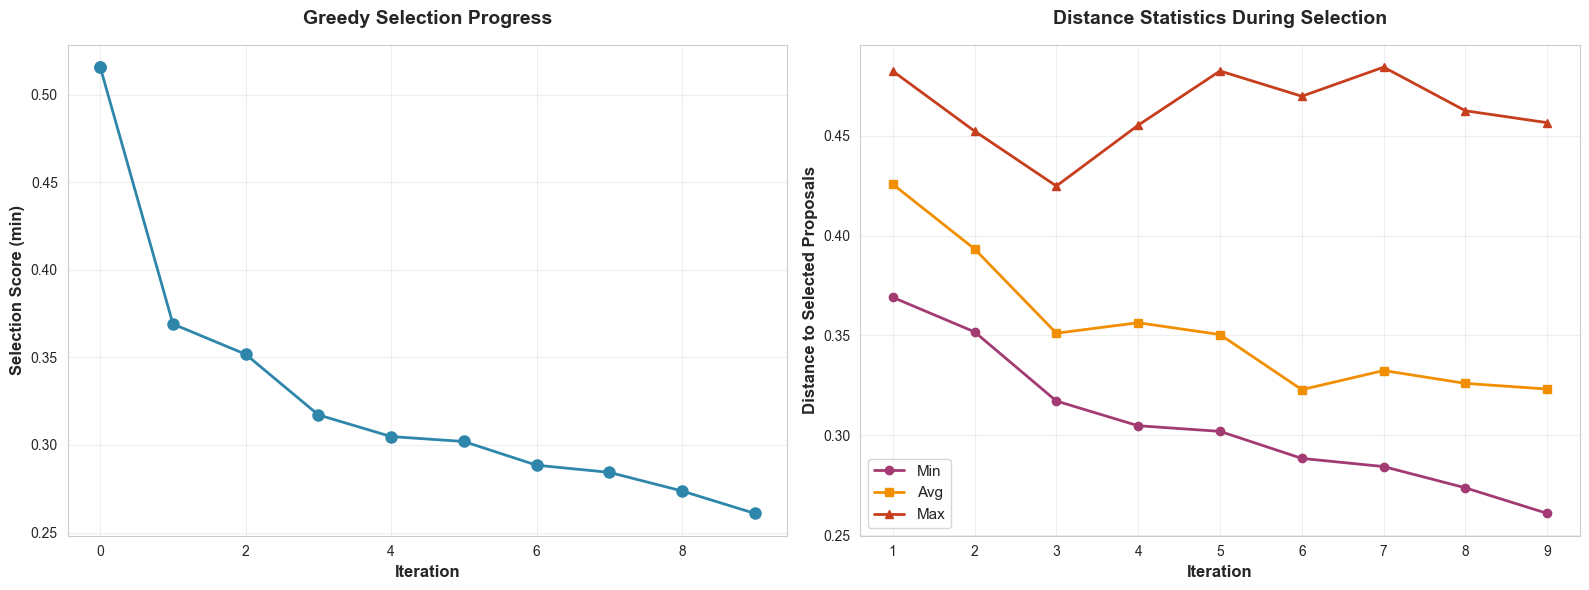

  ✓ Saved: semantic_similarity/similarity_ai-ai/diversity_selection_history.png
Creating baseline comparison plot...


/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_91075/2717771585.py:324: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=['Random\nBaseline', 'Selected\n(Greedy)'],


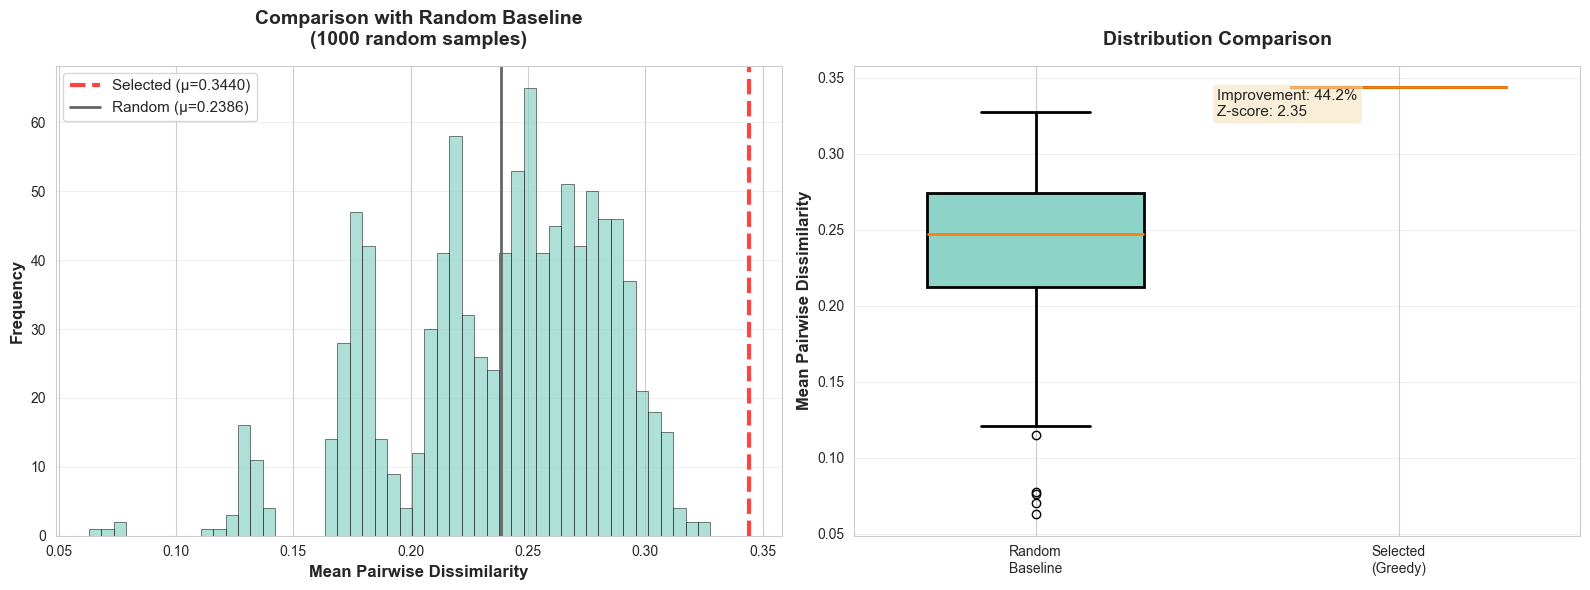

  ✓ Saved: semantic_similarity/similarity_ai-ai/diversity_baseline_comparison.png
Creating distance matrix heatmap...
  (This may take a moment for large datasets...)


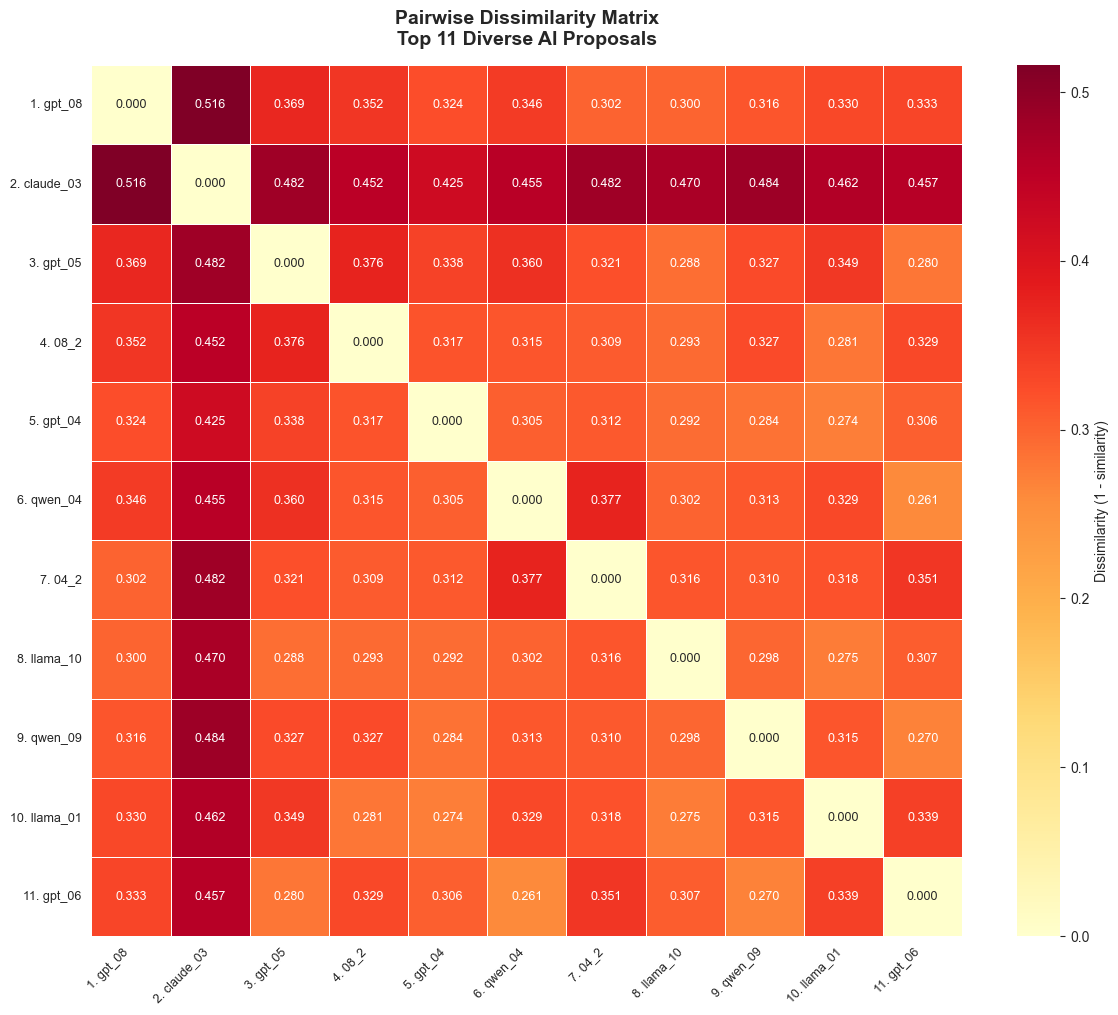

  ✓ Saved: semantic_similarity/similarity_ai-ai/diversity_distance_matrix.png
Creating 2D embedding visualization (MDS)...


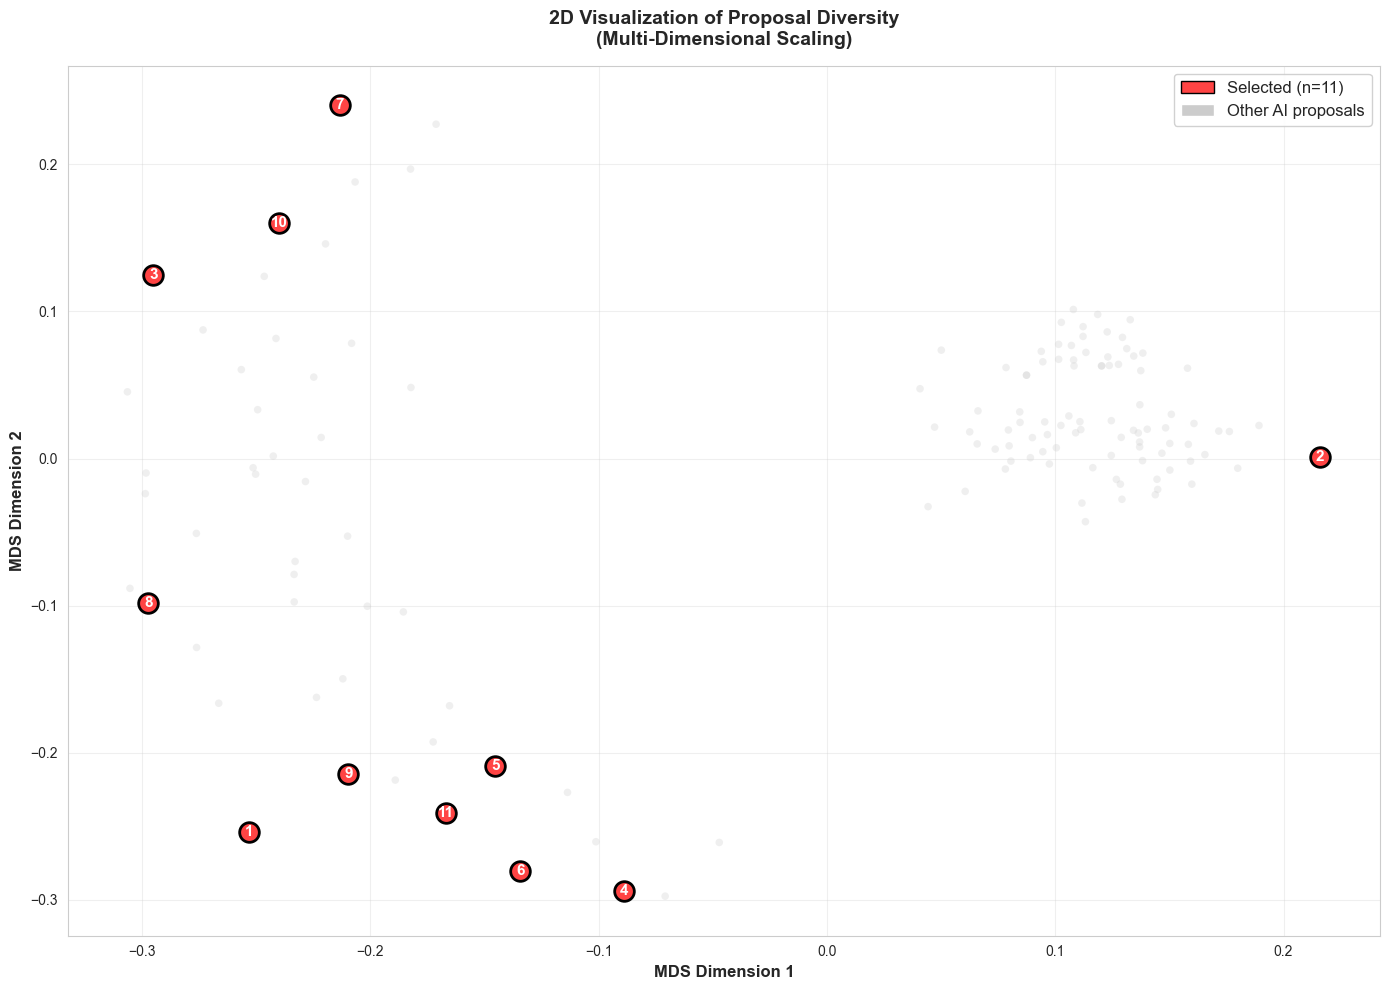

  ✓ Saved: semantic_similarity/similarity_ai-ai/diversity_2d_visualization.png
Creating summary statistics plot...


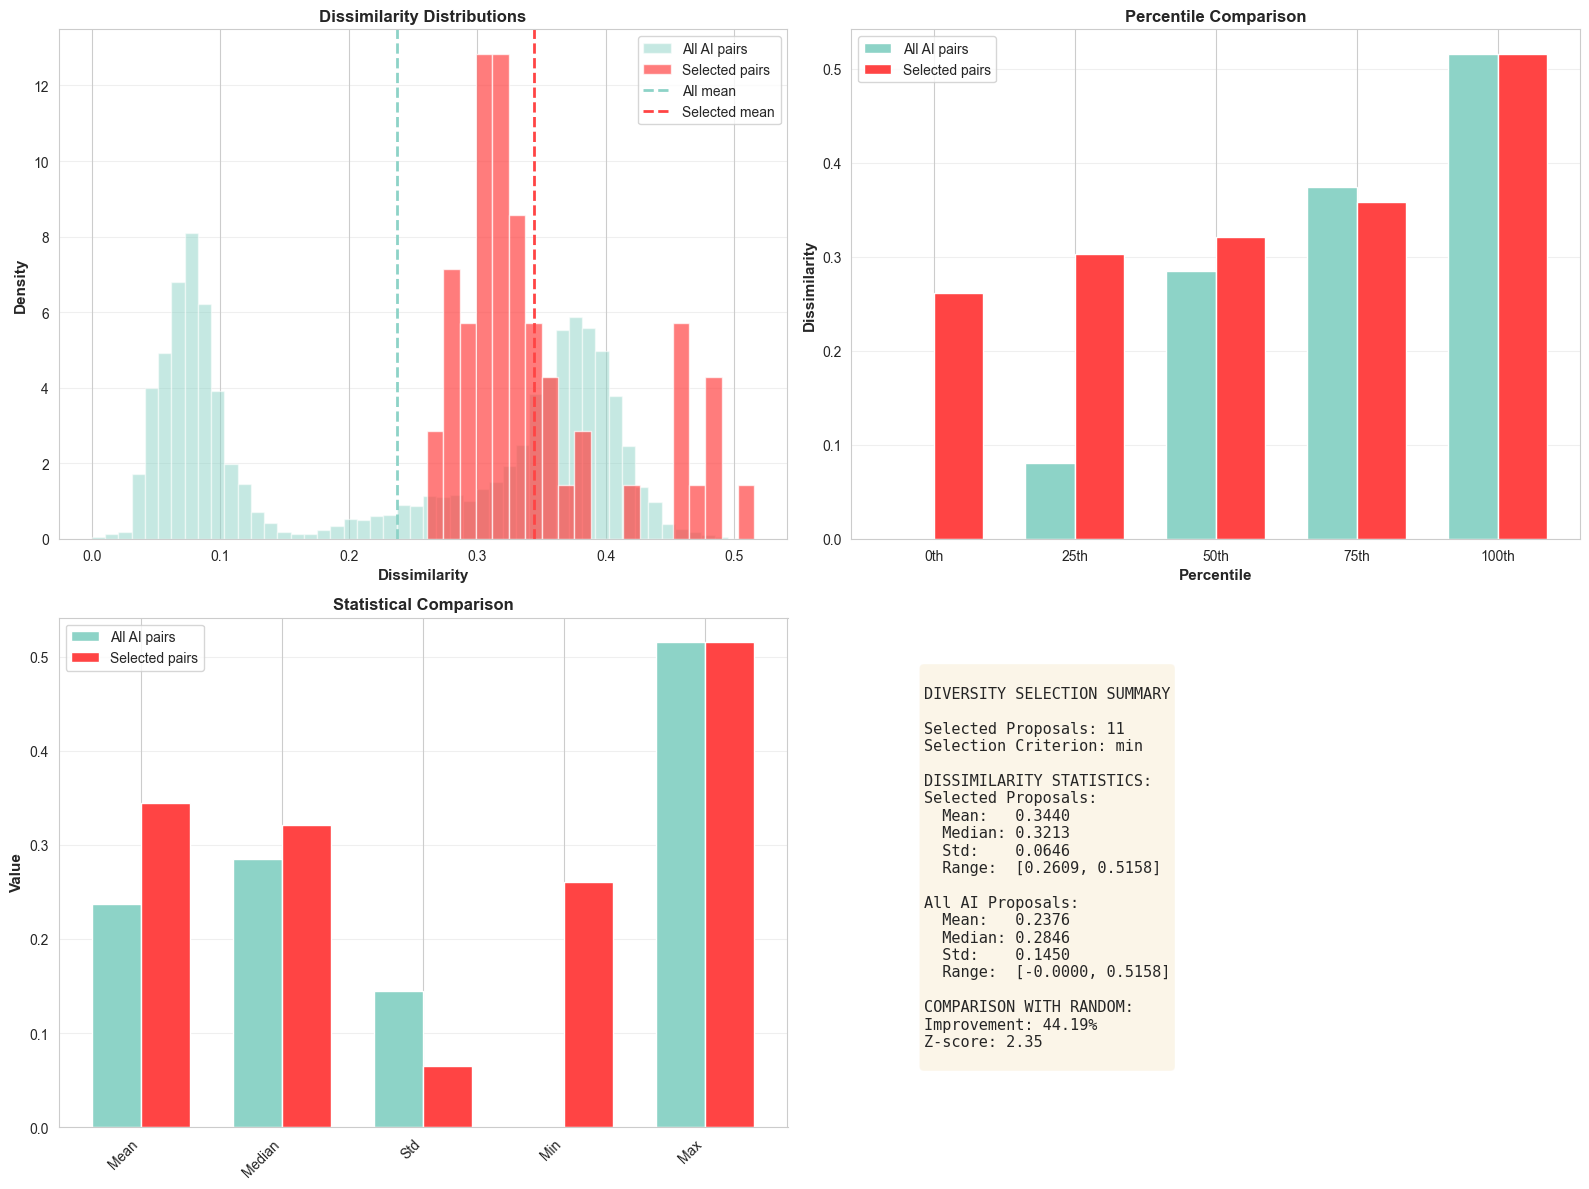

  ✓ Saved: semantic_similarity/similarity_ai-ai/diversity_statistics_summary.png

✓ All visualizations complete!

Results saved to: semantic_similarity/similarity_ai-ai/top_10_diverse_ai_proposals.json

SELECTED TOP 11 DIVERSE AI PROPOSALS
 1. ai_generate_ideas_no_role_gpt_08
 2. ai_generate_diverse_ideas_claude_03
 3. ai_generate_diverse_ideas_gpt_05
 4. ai_generate_diverse_ideas_llama_08_2
 5. ai_generate_diverse_ideas_gpt_04
 6. ai_generate_ideas_no_role_qwen_04
 7. ai_generate_diverse_ideas_llama_04_2
 8. ai_generate_ideas_no_role_llama_10
 9. ai_generate_ideas_no_role_qwen_09
10. ai_generate_diverse_ideas_llama_01
11. ai_generate_diverse_ideas_gpt_06

Selection history saved to: semantic_similarity/top_10_diverse_selection_history.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import json

def load_similarity_csv(csv_file, metric='embedding_similarity'):
    """
    Load pairwise similarities from CSV file
    
    Args:
        csv_file: Path to similarity CSV file
        metric: Which similarity metric column to use
    
    Returns:
        df: DataFrame with similarity data
        proposal_ids: List of unique proposal IDs
    """
    print(f"Loading similarities from {csv_file}...")
    
    # Load CSV
    df = pd.read_csv(csv_file)
    
    # Add dissimilarity column (1 - similarity)
    df['dissimilarity'] = 1.0 - df[metric]
    
    # Get unique proposal IDs
    proposal_ids = sorted(set(df['proposal_1_id'].unique()) | set(df['proposal_2_id'].unique()))
    
    print(f"Loaded {len(df)} pairwise comparisons")
    print(f"Total unique proposals: {len(proposal_ids)}")
    print(f"Using metric: {metric}")
    
    return df, proposal_ids


def greedy_max_dissimilarity_selection_fast(df, proposal_ids, metric='embedding_similarity',
                                            n_select=10, criterion='min'):
    """
    Fast greedy selection using pandas operations
    
    Args:
        df: DataFrame with similarity data
        proposal_ids: List of all proposal IDs
        metric: Similarity metric column name
        n_select: Number of proposals to select
        criterion: 'min' (max-min distance) or 'avg' (max average distance)
    
    Returns:
        selected_proposals: List of selected proposal IDs
        selection_info: Dictionary with selection information
    """
    print(f"\n{'='*70}")
    print(f"GREEDY MAXIMUM DISSIMILARITY SELECTION")
    print(f"{'='*70}")
    print(f"Selecting {n_select} most dissimilar proposals...")
    print(f"Criterion: maximize {criterion} dissimilarity\n")
    
    dissim_col = 'dissimilarity'
    
    # Step 1: Find the two most dissimilar proposals
    print("Step 1: Finding initial pair (most dissimilar)...")
    
    # Sort by dissimilarity and get the top pair
    most_dissimilar = df.nlargest(1, dissim_col).iloc[0]
    initial_pair = [most_dissimilar['proposal_1_id'], most_dissimilar['proposal_2_id']]
    max_dissim = most_dissimilar[dissim_col]
    
    selected = initial_pair.copy()
    selected_set = set(selected)
    
    print(f"  Selected: {initial_pair[0]} <-> {initial_pair[1]}")
    print(f"  Dissimilarity: {max_dissim:.4f}")
    
    # Track selection history
    selection_history = [
        {'iteration': 0, 'selected': initial_pair[0], 'score': max_dissim},
        {'iteration': 0, 'selected': initial_pair[1], 'score': max_dissim}
    ]
    
    # Step 2: Iteratively add proposals
    for iteration in range(n_select - 2):
        print(f"\nIteration {iteration + 1}: Selecting proposal {len(selected) + 1}/{n_select}...")
        
        # Get all pairs involving at least one selected proposal
        mask = (df['proposal_1_id'].isin(selected_set)) | (df['proposal_2_id'].isin(selected_set))
        candidate_pairs = df[mask].copy()
        
        # Identify candidate proposals (not yet selected)
        candidate_pairs['candidate'] = candidate_pairs.apply(
            lambda row: row['proposal_2_id'] if row['proposal_1_id'] in selected_set 
                       else row['proposal_1_id'],
            axis=1
        )
        
        # Remove rows where candidate is already selected
        candidate_pairs = candidate_pairs[~candidate_pairs['candidate'].isin(selected_set)]
        
        if len(candidate_pairs) == 0:
            print(f"  WARNING: No more valid candidates!")
            break
        
        # Group by candidate and calculate score based on criterion
        if criterion == 'min':
            # Max-min: for each candidate, find minimum dissimilarity to selected proposals
            scores = candidate_pairs.groupby('candidate')[dissim_col].min()
        elif criterion == 'avg':
            # Max-avg: for each candidate, find average dissimilarity to selected proposals
            scores = candidate_pairs.groupby('candidate')[dissim_col].mean()
        else:
            raise ValueError(f"Unknown criterion: {criterion}")
        
        # Select candidate with highest score
        best_candidate = scores.idxmax()
        best_score = scores.max()
        
        # Get distance statistics for the selected candidate
        candidate_distances = candidate_pairs[candidate_pairs['candidate'] == best_candidate][dissim_col]
        
        selected.append(best_candidate)
        selected_set.add(best_candidate)
        
        selection_history.append({
            'iteration': iteration + 1,
            'selected': best_candidate,
            'score': best_score,
            'min_distance': candidate_distances.min(),
            'max_distance': candidate_distances.max(),
            'avg_distance': candidate_distances.mean()
        })
        
        print(f"  Selected: {best_candidate}")
        print(f"  Score ({criterion}): {best_score:.4f}")
        print(f"  Distance stats: min={candidate_distances.min():.4f}, "
              f"max={candidate_distances.max():.4f}, avg={candidate_distances.mean():.4f}")
    
    # Calculate final statistics
    print(f"\n{'='*70}")
    print(f"SELECTION COMPLETE")
    print(f"{'='*70}")
    print(f"Selected {len(selected)} proposals\n")
    
    # Get all pairwise distances among selected proposals
    mask_selected = (df['proposal_1_id'].isin(selected_set)) & (df['proposal_2_id'].isin(selected_set))
    selected_pairs = df[mask_selected]
    pairwise_distances = selected_pairs[dissim_col]
    
    selection_info = {
        'selected_proposals': selected,
        'n_selected': len(selected),
        'criterion': criterion,
        'metric': metric,
        'selection_history': selection_history,
        'pairwise_distance_stats': {
            'mean': pairwise_distances.mean(),
            'std': pairwise_distances.std(),
            'min': pairwise_distances.min(),
            'max': pairwise_distances.max(),
            'median': pairwise_distances.median(),
            'n_pairs': len(pairwise_distances)
        }
    }
    
    print(f"Pairwise dissimilarity statistics among selected proposals:")
    print(f"  Mean:   {selection_info['pairwise_distance_stats']['mean']:.4f}")
    print(f"  Std:    {selection_info['pairwise_distance_stats']['std']:.4f}")
    print(f"  Min:    {selection_info['pairwise_distance_stats']['min']:.4f}")
    print(f"  Max:    {selection_info['pairwise_distance_stats']['max']:.4f}")
    print(f"  Median: {selection_info['pairwise_distance_stats']['median']:.4f}")
    print(f"  Pairs:  {selection_info['pairwise_distance_stats']['n_pairs']}")
    
    return selected, selection_info


def compare_with_random_baseline_fast(df, proposal_ids, metric='embedding_similarity',
                                      n_select=10, n_iterations=1000, seed=42):
    """
    Compare with random baseline using pandas operations
    """
    print(f"\n{'='*70}")
    print(f"RANDOM BASELINE COMPARISON")
    print(f"{'='*70}")
    print(f"Running {n_iterations} random samples...")
    
    np.random.seed(seed)
    dissim_col = 'dissimilarity'
    random_means = []
    
    for i in range(n_iterations):
        # Random sample
        random_sample = np.random.choice(proposal_ids, size=n_select, replace=False)
        random_set = set(random_sample)
        
        # Get pairwise distances for this sample
        mask = (df['proposal_1_id'].isin(random_set)) & (df['proposal_2_id'].isin(random_set))
        sample_pairs = df[mask]
        
        if len(sample_pairs) > 0:
            random_means.append(sample_pairs[dissim_col].mean())
    
    random_means = np.array(random_means)
    
    baseline_stats = {
        'mean': random_means.mean(),
        'std': random_means.std(),
        'min': random_means.min(),
        'max': random_means.max(),
        'percentiles': {
            'p5': np.percentile(random_means, 5),
            'p25': np.percentile(random_means, 25),
            'p50': np.percentile(random_means, 50),
            'p75': np.percentile(random_means, 75),
            'p95': np.percentile(random_means, 95)
        }
    }
    
    print(f"\nRandom baseline statistics:")
    print(f"  Mean: {baseline_stats['mean']:.4f} ± {baseline_stats['std']:.4f}")
    print(f"  Range: [{baseline_stats['min']:.4f}, {baseline_stats['max']:.4f}]")
    print(f"  Percentiles:")
    print(f"    p5:  {baseline_stats['percentiles']['p5']:.4f}")
    print(f"    p25: {baseline_stats['percentiles']['p25']:.4f}")
    print(f"    p50: {baseline_stats['percentiles']['p50']:.4f}")
    print(f"    p75: {baseline_stats['percentiles']['p75']:.4f}")
    print(f"    p95: {baseline_stats['percentiles']['p95']:.4f}")
    
    return baseline_stats, random_means


def create_distance_matrix(df, proposal_ids, metric='embedding_similarity'):
    """
    Create a distance matrix from pairwise similarity data
    """
    n = len(proposal_ids)
    distance_matrix = np.zeros((n, n))
    id_to_idx = {pid: idx for idx, pid in enumerate(proposal_ids)}
    
    dissim_col = 'dissimilarity'
    
    for _, row in df.iterrows():
        i = id_to_idx[row['proposal_1_id']]
        j = id_to_idx[row['proposal_2_id']]
        dist = row[dissim_col]
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist
    
    return distance_matrix, id_to_idx


def visualize_diversity_selection(df, proposal_ids, selected_proposals, selection_info, 
                                  baseline_stats, random_means, output_dir='semantic_similarity'):
    """
    Create comprehensive visualizations of the diversity selection
    """
    print(f"\n{'='*70}")
    print(f"CREATING VISUALIZATIONS")
    print(f"{'='*70}")
    
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True, parents=True)
    
    # Set style
    sns.set_style("whitegrid")
    
    # 1. Selection history plot
    print("Creating selection history plot...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    history_df = pd.DataFrame(selection_info['selection_history'])
    
    # Plot scores over iterations
    ax1.plot(history_df['iteration'], history_df['score'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
    ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel(f'Selection Score ({selection_info["criterion"]})', fontsize=12, fontweight='bold')
    ax1.set_title('Greedy Selection Progress', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(alpha=0.3)
    
    # Plot distance statistics (skip first two iterations - initial pair)
    if len(history_df) > 2:
        history_stats = history_df[2:].copy()  # Skip initial pair
        x = history_stats['iteration']
        ax2.plot(x, history_stats['min_distance'], 'o-', label='Min', linewidth=2, markersize=6, color='#A23B72')
        ax2.plot(x, history_stats['avg_distance'], 's-', label='Avg', linewidth=2, markersize=6, color='#F18F01')
        ax2.plot(x, history_stats['max_distance'], '^-', label='Max', linewidth=2, markersize=6, color='#C73E1D')
        ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Distance to Selected Proposals', fontsize=12, fontweight='bold')
        ax2.set_title('Distance Statistics During Selection', fontsize=14, fontweight='bold', pad=15)
        ax2.legend(fontsize=11)
        ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path / 'diversity_selection_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {output_path / 'diversity_selection_history.png'}")
    
    # 2. Comparison with random baseline
    print("Creating baseline comparison plot...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram of random samples
    ax1.hist(random_means, bins=50, alpha=0.7, color='#8DD3C7', edgecolor='black', linewidth=0.5)
    selected_mean = selection_info['pairwise_distance_stats']['mean']
    ax1.axvline(selected_mean, color='#FF4444', linewidth=3, linestyle='--', 
                label=f'Selected (μ={selected_mean:.4f})')
    ax1.axvline(baseline_stats['mean'], color='#666666', linewidth=2, linestyle='-', 
                label=f'Random (μ={baseline_stats["mean"]:.4f})')
    ax1.set_xlabel('Mean Pairwise Dissimilarity', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Comparison with Random Baseline\n(1000 random samples)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax1.legend(fontsize=11)
    ax1.grid(alpha=0.3, axis='y')
    
    # Box plot comparison
    comparison_data = pd.DataFrame({
        'Random Baseline': random_means,
        'Selected\n(Greedy)': [selected_mean] * len(random_means)
    })
    
    box_data = [random_means, [selected_mean]]
    bp = ax2.boxplot(box_data, labels=['Random\nBaseline', 'Selected\n(Greedy)'],
                     patch_artist=True, widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('#8DD3C7')
    bp['boxes'][1].set_facecolor('#FF4444')
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], linewidth=2)
    
    ax2.set_ylabel('Mean Pairwise Dissimilarity', fontsize=12, fontweight='bold')
    ax2.set_title('Distribution Comparison', fontsize=14, fontweight='bold', pad=15)
    ax2.grid(alpha=0.3, axis='y')
    
    # Add improvement text
    improvement = (selected_mean - baseline_stats['mean']) / baseline_stats['mean'] * 100
    z_score = (selected_mean - baseline_stats['mean']) / baseline_stats['std']
    ax2.text(0.5, 0.95, f'Improvement: {improvement:.1f}%\nZ-score: {z_score:.2f}',
             transform=ax2.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(output_path / 'diversity_baseline_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {output_path / 'diversity_baseline_comparison.png'}")
    
    # 3. Distance matrix heatmap
    print("Creating distance matrix heatmap...")
    print("  (This may take a moment for large datasets...)")
    
    # Create distance matrix for selected proposals only
    selected_set = set(selected_proposals)
    mask_selected = (df['proposal_1_id'].isin(selected_set)) & (df['proposal_2_id'].isin(selected_set))
    selected_pairs = df[mask_selected]
    
    n_selected = len(selected_proposals)
    distance_matrix = np.zeros((n_selected, n_selected))
    id_to_idx = {pid: idx for idx, pid in enumerate(selected_proposals)}
    
    for _, row in selected_pairs.iterrows():
        i = id_to_idx[row['proposal_1_id']]
        j = id_to_idx[row['proposal_2_id']]
        dist = row['dissimilarity']
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create labels with numbers
    labels = [f"{i+1}. {pid.split('_')[-2]}_{pid.split('_')[-1]}" 
              for i, pid in enumerate(selected_proposals)]
    
    sns.heatmap(distance_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
                xticklabels=labels, yticklabels=labels, ax=ax,
                cbar_kws={'label': 'Dissimilarity (1 - similarity)'},
                linewidths=0.5, linecolor='white', square=True,
                annot_kws={'size': 9})
    
    ax.set_title(f'Pairwise Dissimilarity Matrix\nTop {n_selected} Diverse AI Proposals', 
                 fontsize=14, fontweight='bold', pad=15)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    
    plt.tight_layout()
    plt.savefig(output_path / 'diversity_distance_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {output_path / 'diversity_distance_matrix.png'}")
    
    # 4. 2D visualization using MDS (Multi-Dimensional Scaling)
    print("Creating 2D embedding visualization (MDS)...")
    from sklearn.manifold import MDS
    
    # Create full distance matrix for all proposals (sample if too large)
    max_proposals_for_viz = 500
    if len(proposal_ids) > max_proposals_for_viz:
        print(f"  Sampling {max_proposals_for_viz} proposals for visualization (too many to plot all)")
        # Always include selected proposals
        other_proposals = [p for p in proposal_ids if p not in selected_set]
        sampled_others = np.random.choice(other_proposals, 
                                        size=min(max_proposals_for_viz - len(selected_proposals), 
                                               len(other_proposals)), 
                                        replace=False)
        viz_proposals = selected_proposals + list(sampled_others)
    else:
        viz_proposals = proposal_ids
    
    # Create distance matrix for visualization
    distance_matrix_viz, id_to_idx_viz = create_distance_matrix(df, viz_proposals)
    
    # Apply MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(distance_matrix_viz)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot all proposals
    is_selected = [p in selected_set for p in viz_proposals]
    colors = ['#FF4444' if sel else '#CCCCCC' for sel in is_selected]
    sizes = [200 if sel else 30 for sel in is_selected]
    alphas = [1.0 if sel else 0.3 for sel in is_selected]
    
    for i, (x, y) in enumerate(coords):
        ax.scatter(x, y, c=colors[i], s=sizes[i], alpha=alphas[i], 
                  edgecolors='black' if is_selected[i] else 'none', linewidth=2)
        
        # Label selected proposals
        if is_selected[i]:
            label_num = selected_proposals.index(viz_proposals[i]) + 1
            ax.annotate(f'{label_num}', (x, y), fontsize=11, fontweight='bold',
                       ha='center', va='center', color='white')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF4444', edgecolor='black', label=f'Selected (n={len(selected_proposals)})'),
        Patch(facecolor='#CCCCCC', label=f'Other AI proposals')
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=12, framealpha=0.9)
    
    ax.set_xlabel('MDS Dimension 1', fontsize=12, fontweight='bold')
    ax.set_ylabel('MDS Dimension 2', fontsize=12, fontweight='bold')
    ax.set_title('2D Visualization of Proposal Diversity\n(Multi-Dimensional Scaling)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path / 'diversity_2d_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {output_path / 'diversity_2d_visualization.png'}")
    
    # 5. Summary statistics comparison
    print("Creating summary statistics plot...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Get statistics for all proposals
    all_distances = df['dissimilarity'].values
    selected_distances = selected_pairs['dissimilarity'].values
    
    # Plot 1: Distribution comparison
    ax = axes[0, 0]
    ax.hist(all_distances, bins=50, alpha=0.5, label='All AI pairs', color='#8DD3C7', density=True)
    ax.hist(selected_distances, bins=20, alpha=0.7, label='Selected pairs', color='#FF4444', density=True)
    ax.axvline(np.mean(all_distances), color='#8DD3C7', linestyle='--', linewidth=2, label='All mean')
    ax.axvline(np.mean(selected_distances), color='#FF4444', linestyle='--', linewidth=2, label='Selected mean')
    ax.set_xlabel('Dissimilarity', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title('Dissimilarity Distributions', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, axis='y')
    
    # Plot 2: Percentile comparison
    ax = axes[0, 1]
    percentiles = [0, 25, 50, 75, 100]
    all_percentiles = np.percentile(all_distances, percentiles)
    selected_percentiles = np.percentile(selected_distances, percentiles)
    
    x = np.arange(len(percentiles))
    width = 0.35
    ax.bar(x - width/2, all_percentiles, width, label='All AI pairs', color='#8DD3C7')
    ax.bar(x + width/2, selected_percentiles, width, label='Selected pairs', color='#FF4444')
    ax.set_xlabel('Percentile', fontsize=11, fontweight='bold')
    ax.set_ylabel('Dissimilarity', fontsize=11, fontweight='bold')
    ax.set_title('Percentile Comparison', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{p}th' for p in percentiles])
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, axis='y')
    
    # Plot 3: Statistics bars
    ax = axes[1, 0]
    metrics = ['Mean', 'Median', 'Std', 'Min', 'Max']
    all_stats = [np.mean(all_distances), np.median(all_distances), np.std(all_distances),
                 np.min(all_distances), np.max(all_distances)]
    selected_stats = [np.mean(selected_distances), np.median(selected_distances), np.std(selected_distances),
                     np.min(selected_distances), np.max(selected_distances)]
    
    x = np.arange(len(metrics))
    width = 0.35
    ax.bar(x - width/2, all_stats, width, label='All AI pairs', color='#8DD3C7')
    ax.bar(x + width/2, selected_stats, width, label='Selected pairs', color='#FF4444')
    ax.set_ylabel('Value', fontsize=11, fontweight='bold')
    ax.set_title('Statistical Comparison', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, axis='y')
    
    # Plot 4: Text summary
    ax = axes[1, 1]
    ax.axis('off')
    
    summary_text = f"""
DIVERSITY SELECTION SUMMARY

Selected Proposals: {len(selected_proposals)}
Selection Criterion: {selection_info['criterion']}

DISSIMILARITY STATISTICS:
Selected Proposals:
  Mean:   {np.mean(selected_distances):.4f}
  Median: {np.median(selected_distances):.4f}
  Std:    {np.std(selected_distances):.4f}
  Range:  [{np.min(selected_distances):.4f}, {np.max(selected_distances):.4f}]

All AI Proposals:
  Mean:   {np.mean(all_distances):.4f}
  Median: {np.median(all_distances):.4f}
  Std:    {np.std(all_distances):.4f}
  Range:  [{np.min(all_distances):.4f}, {np.max(all_distances):.4f}]

COMPARISON WITH RANDOM:
Improvement: {improvement:.2f}%
Z-score: {z_score:.2f}
    """
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.savefig(output_path / 'diversity_statistics_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {output_path / 'diversity_statistics_summary.png'}")
    
    print(f"\n{'='*70}")
    print(f"✓ All visualizations complete!")
    print(f"{'='*70}")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

# Load similarity data
csv_file = 'semantic_similarity/similarity_ai-ai/similarity_ai-ai_20251107_115027.csv'

df, proposal_ids = load_similarity_csv(csv_file, metric='embedding_similarity')

# Perform greedy selection
selected_proposals, selection_info = greedy_max_dissimilarity_selection_fast(
    df=df,
    proposal_ids=proposal_ids,
    metric='embedding_similarity',
    n_select=11,
    criterion='min'  # or 'avg'
)

# Compare with random baseline
baseline_stats, random_means = compare_with_random_baseline_fast(
    df=df,
    proposal_ids=proposal_ids,
    metric='embedding_similarity',
    n_select=11,
    n_iterations=1000
)

# Calculate improvement
improvement = (selection_info['pairwise_distance_stats']['mean'] - baseline_stats['mean']) / baseline_stats['mean'] * 100
z_score = (selection_info['pairwise_distance_stats']['mean'] - baseline_stats['mean']) / baseline_stats['std']

print(f"\n{'='*70}")
print(f"COMPARISON WITH BASELINE")
print(f"{'='*70}")
print(f"Selected proposals mean dissimilarity: {selection_info['pairwise_distance_stats']['mean']:.4f}")
print(f"Random baseline mean dissimilarity:    {baseline_stats['mean']:.4f}")
print(f"Improvement: {improvement:.2f}%")
print(f"Z-score: {z_score:.2f} (effect size)")

# Create visualizations
visualize_diversity_selection(
    df=df,
    proposal_ids=proposal_ids,
    selected_proposals=selected_proposals,
    selection_info=selection_info,
    baseline_stats=baseline_stats,
    random_means=random_means,
    output_dir='semantic_similarity/similarity_ai-ai'
)

# Save results
output_file = 'semantic_similarity/similarity_ai-ai/top_10_diverse_ai_proposals.json'
with open(output_file, 'w') as f:
    json.dump({
        'selected_proposals': selected_proposals,
        'selection_info': selection_info,
        'baseline_stats': baseline_stats,
        'improvement_over_baseline_pct': improvement,
        'z_score': z_score
    }, f, indent=2)

print(f"\nResults saved to: {output_file}")

# Print selected proposals in a nice format
print(f"\n{'='*70}")
print(f"SELECTED TOP 11 DIVERSE AI PROPOSALS")
print(f"{'='*70}")
for i, prop_id in enumerate(selected_proposals, 1):
    print(f"{i:2d}. {prop_id}")

# Create a summary DataFrame
summary_df = pd.DataFrame(selection_info['selection_history'])
summary_df.to_csv('semantic_similarity/top_10_diverse_selection_history.csv', index=False)
print(f"\nSelection history saved to: semantic_similarity/top_10_diverse_selection_history.csv")

### before the next step calculate similarity of those proposals using calculate_semantic_similarity with --json-files argument

In [9]:
# Define paths to similarity files for comparison
similarity_files = {
    'Human': '/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_human-human/similarity_human-human_20251107_103532.json',
    'AI (top 11)':'/Users/eveyhuang/Documents/NICO/ai-scientist/semantic_similarity/similarity_ai-ai/similarity_top_10_diverse_ai_proposals.json'    
}

print("Similarity files to compare:")
for comp_type, path in similarity_files.items():
    if Path(path).exists():
        print(f"  {comp_type}: {Path(path).name}")
        print(f"    Exists: ✓")
    else:
        print(f"  {comp_type}: NOT FOUND")

Similarity files to compare:
  Human: similarity_human-human_20251107_103532.json
    Exists: ✓
  AI (top 11): similarity_top_10_diverse_ai_proposals.json
    Exists: ✓


In [10]:
# Load and extract similarity metrics from all JSON files
def extract_similarity_metrics(sim_file_path):
    """Extract all similarity metrics from a similarity JSON file"""
    with open(sim_file_path, 'r') as f:
        data = json.load(f)
    
    results = data['results']
    
    # Dictionary to store metrics
    metrics = {
        'tfidf_cosine_similarity': [],
        'embedding_cosine_similarity': [],
        'keyword_jaccard': [],
        'topic_lda_cosine': []
    }
    
    for result in results:
        
        if 'similarity_metrics' not in result.keys():
            continue

        sim_metrics = result['similarity_metrics']
        
        # Extract metrics safely
        tfidf_val = sim_metrics.get('tfidf_cosine_similarity')
        metrics['tfidf_cosine_similarity'].append(tfidf_val if isinstance(tfidf_val, (int, float)) else np.nan)
        
        emb_val = sim_metrics.get('embedding_cosine_similarity')
        metrics['embedding_cosine_similarity'].append(emb_val if isinstance(emb_val, (int, float)) else np.nan)
        
        # Extract keyword jaccard
        keyword_overlap = sim_metrics.get('keyword_overlap', {})
        kw_val = keyword_overlap.get('jaccard_similarity') if isinstance(keyword_overlap, dict) else None
        metrics['keyword_jaccard'].append(kw_val if isinstance(kw_val, (int, float)) else np.nan)
        
        # Extract topic LDA cosine
        topic_overlap = sim_metrics.get('topic_overlap', {})
        topic_val = topic_overlap.get('lda_cosine_similarity') if isinstance(topic_overlap, dict) else None
        metrics['topic_lda_cosine'].append(topic_val if isinstance(topic_val, (int, float)) else np.nan)
    
    return metrics

def is_valid_number(v):
    """Check if value is a valid number (not None, not NaN)"""
    return v is not None and isinstance(v, (int, float)) and not np.isnan(v)

# Extract metrics from all similarity files
all_similarity_metrics = {}
for comp_type, sim_file in similarity_files.items():
    if Path(sim_file).exists():
        all_similarity_metrics[comp_type] = extract_similarity_metrics(sim_file)
        print(f"Loaded {comp_type}:")
        for metric_name, values in all_similarity_metrics[comp_type].items():
            valid_values = [v for v in values if is_valid_number(v)]
            if len(valid_values) > 0:
                print(f"  {metric_name}: {len(valid_values)} values (mean: {np.mean(valid_values):.3f})")
            else:
                print(f"  {metric_name}: 0 valid values")
    else:
        print(f"Warning: {comp_type} file not found!")

print(f"\nTotal comparison types loaded: {len(all_similarity_metrics)}")


Loaded Human:
  tfidf_cosine_similarity: 110 values (mean: 0.159)
  embedding_cosine_similarity: 110 values (mean: 0.732)
  keyword_jaccard: 110 values (mean: 0.065)
  topic_lda_cosine: 0 valid values
Loaded AI (top 11):
  tfidf_cosine_similarity: 110 values (mean: 0.180)
  embedding_cosine_similarity: 110 values (mean: 0.656)
  keyword_jaccard: 110 values (mean: 0.077)
  topic_lda_cosine: 0 valid values

Total comparison types loaded: 2


In [14]:
# Automatically generate colors based on comparison types (not metrics)
comp_types_list = list(all_similarity_metrics.keys())
n_comp_types = len(comp_types_list)

# Create color dictionary with human-human standing out
sim_colors = {}
for i, comp_type in enumerate(comp_types_list):
    if 'human' in comp_type.lower():
        # Use a bright, distinctive color for human-human (e.g., red or orange)
        sim_colors[comp_type] = '#FF4444'  # Bright red
        # Or try: '#FF8C00' (dark orange), '#FF1493' (deep pink), '#00CED1' (dark turquoise)
    else:
        # Use muted colors for other comparison types
        cmap = plt.cm.get_cmap('Set2')  # or 'Pastel1' for even more muted
        sim_colors[comp_type] = cmap(i / max(n_comp_types - 1, 1))

# Create combined histogram plot for all metrics with side-by-side bars
n_metrics = len(all_sim_metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] if n_cols == 1 else axes.flatten()

# Number of bins for histograms (0 to 1)
n_bins = 20

for idx, metric in enumerate(all_sim_metrics):
    ax = axes[idx]
    
    # Get comparison types that have this metric
    comp_types_with_metric = [ct for ct in all_similarity_metrics.keys()]
    n_comp_types = len(comp_types_with_metric)
    
    # Calculate bar width
    bin_width = 1.0 / n_bins
    bar_width = bin_width / n_comp_types * 0.8
    
    # Plot bars for each comparison type (side-by-side)
    for i, comp_type in enumerate(comp_types_with_metric):
        values = all_similarity_metrics[comp_type][metric]
        valid_values = [v for v in values if is_valid_number(v)]
        
        if len(valid_values) > 0:
            # Create histogram bins
            counts, bin_edges = np.histogram(valid_values, bins=n_bins, range=(0, 1))
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Calculate x positions (offset for each comparison type)
            x_positions = bin_centers + (i - n_comp_types/2 + 0.5) * bar_width
            
            ax.bar(x_positions, counts, width=bar_width,
                   label=f'{comp_type} (n={len(valid_values)}, μ={np.mean(valid_values):.3f})',
                   color=sim_colors.get(comp_type, 'gray'),
                   edgecolor='black', linewidth=0.5, alpha=0.8)
    
    ax.set_xlabel('Similarity Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(sim_metric_names[metric], fontsize=12, fontweight='bold', pad=10)
    
    # Move legend to upper left for embedding similarity, keep upper right for others
    if 'embedding' in metric.lower():
        ax.legend(loc='upper left', fontsize=9)
    else:
        ax.legend(loc='upper right', fontsize=9)
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_xlim(0, 1)

# Hide unused subplots
for idx in range(len(all_sim_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Semantic Similarity Distributions by Metric', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_91075/2053250012.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2')  # or 'Pastel1' for even more muted


NameError: name 'all_sim_metrics' is not defined

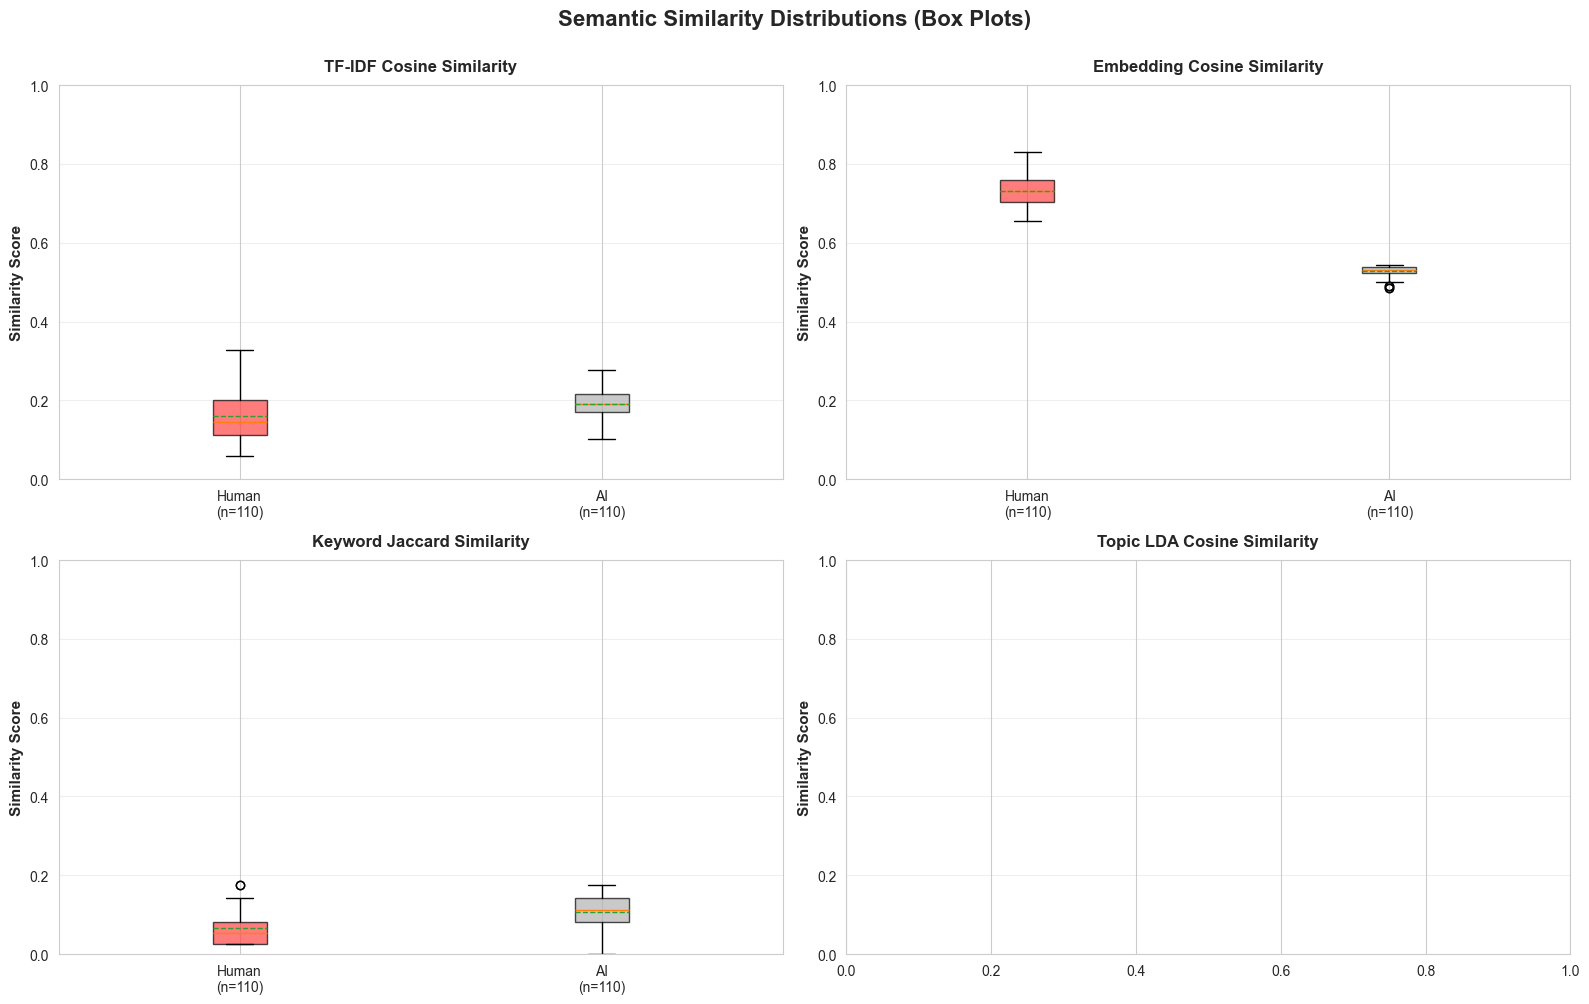

In [38]:
# Box plots for comparative similarity analysis
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] if n_cols == 1 else axes.flatten()

for idx, metric in enumerate(all_sim_metrics):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_to_plot = []
    labels = []
    
    for comp_type in all_similarity_metrics.keys():
        metric_values = all_similarity_metrics[comp_type][metric]
        valid_values = [v for v in metric_values if is_valid_number(v)]
        if len(valid_values) > 0:
            data_to_plot.append(valid_values)
            labels.append(f'{comp_type}\n(n={len(valid_values)})')
    
    if len(data_to_plot) > 0:
        # Create box plot
        bp = ax.boxplot(data_to_plot, tick_labels=labels, patch_artist=True,
                         showmeans=True, meanline=True)
        
        # Color the boxes
        for patch_idx, comp_type in enumerate(all_similarity_metrics.keys()):
            bp['boxes'][patch_idx].set_facecolor(sim_colors.get(comp_type, 'lightgray'))
            bp['boxes'][patch_idx].set_alpha(0.7)
    
    ax.set_ylabel('Similarity Score', fontsize=11, fontweight='bold')
    ax.set_title(sim_metric_names[metric], fontsize=12, fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)

# Hide unused subplots
for idx in range(len(all_sim_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Semantic Similarity Distributions (Box Plots)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
#plt.savefig('semantic_similarity/similarity_boxplots_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



In [39]:
# Statistical comparison between comparison types for similarity metrics
print("="*80)
print("STATISTICAL COMPARISON (Mann-Whitney U Test) - Similarity Metrics")
print("="*80)

# Get all comparison type pairs
sim_comp_types = list(all_similarity_metrics.keys())

if len(sim_comp_types) >= 2:
    for metric in all_sim_metrics:
        print(f"\n{sim_metric_names[metric]}:")
        
        # Compare all pairs
        for i, comp_type1 in enumerate(sim_comp_types):
            for comp_type2 in enumerate(sim_comp_types[i+1:], start=i+1):
                comp_type2_name = sim_comp_types[comp_type2[0]]
                
                values1 = all_similarity_metrics[comp_type1][metric]
                values2 = all_similarity_metrics[comp_type2_name][metric]
                
                valid_values1 = [v for v in values1 if is_valid_number(v)]
                valid_values2 = [v for v in values2 if is_valid_number(v)]
                
                if len(valid_values1) > 0 and len(valid_values2) > 0:
                    # Perform Mann-Whitney U test
                    statistic, p_value = stats.mannwhitneyu(valid_values1, valid_values2, alternative='two-sided')
                    
                    mean1 = np.mean(valid_values1)
                    mean2 = np.mean(valid_values2)
                    diff = mean1 - mean2
                    
                    # Effect size (Cohen's d)
                    pooled_std = np.sqrt((np.std(valid_values1)**2 + np.std(valid_values2)**2) / 2)
                    cohens_d = diff / pooled_std if pooled_std > 0 else 0
                    
                    sig_marker = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    
                    print(f"  {comp_type1} vs {comp_type2_name}:")
                    print(f"    Means: {mean1:.4f} vs {mean2:.4f} (diff: {diff:+.4f})")
                    print(f"    p-value: {p_value:.4f} {sig_marker}")
                    print(f"    Cohen's d: {cohens_d:.3f}")
else:
    print("\nNeed at least 2 comparison types for statistical testing.")
    print("Add more similarity files to the 'similarity_files' dictionary above.")

print("\n" + "="*80)
print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("="*80)


STATISTICAL COMPARISON (Mann-Whitney U Test) - Similarity Metrics

TF-IDF Cosine Similarity:
  Human vs AI:
    Means: 0.1594 vs 0.1913 (diff: -0.0319)
    p-value: 0.0000 ***
    Cohen's d: -0.639

Embedding Cosine Similarity:
  Human vs AI:
    Means: 0.7325 vs 0.5281 (diff: +0.2044)
    p-value: 0.0000 ***
    Cohen's d: 7.209

Keyword Jaccard Similarity:
  Human vs AI:
    Means: 0.0650 vs 0.1074 (diff: -0.0424)
    p-value: 0.0000 ***
    Cohen's d: -1.132

Topic LDA Cosine Similarity:

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant
